## Questa cella esegue il login su wandb

In [1]:
import wandb
from wandb import Api
import pandas as pd
import os
import shutil

# === CONFIGURAZIONE ===
sweeps_mapping = {
    "7ovklbta" : "YOLOv11s", # Sweep Bayesian
    "4q1q0ld1" : "YOLOv11s", # Sweep with the initial run
    "7e7521i8": "YOLOv11n",  # Sweep Bayesian
    "so0hcj67": "YOLOv11n",  # Sweep with the initial run 

}

ENTITY = "pothole-detector"
PROJECT = "pothole-detector-NatureSR"

# === LOGIN ===
wandb.login(key="72b4ec15df63ad11199671a179e6d14005751df2")

# === SETUP ===
api = Api()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/lorenzo/.netrc
wandb: Currently logged in as: lorenzo-arcioni to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Download dei dati da wandb

In [2]:
# === ESTRAZIONE DEI DATI ===
all_runs_data = []

summary_useful = [
    'lr/pg0', 
    'lr/pg1', 
    'lr/pg2', 
    'metrics/mAP50(B)', 
    'metrics/mAP50-95(B)', 
    'metrics/precision(B)', 
    'metrics/recall(B)', 
    'model/GFLOPs', 
    'model/parameters', 
    'model/speed_PyTorch(ms)', 
    'train/box_loss', 
    'train/cls_loss', 
    'train/dfl_loss',
    'val/box_loss',
    'val/cls_loss', 
    'val/dfl_loss',
]

# === CICLO SU TUTTI GLI SWEEP ===
# Carica sweep

OUTPUT_DIR = {sweep_id: f"results/{name}" for sweep_id, name in sweeps_mapping.items()}

for sweep_id in sweeps_mapping:
    out_dir = OUTPUT_DIR[sweep_id]
    os.makedirs(out_dir, exist_ok=True)
    print(f"\n📦 Sweep {sweep_id} → output in '{out_dir}'")
    
    try:
        sweep = api.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}")
        runs = sweep.runs
        print(f"🔍 Trovati {len(runs)} run")
        
        for run in runs:
            run_id = run.id
            run_name = run.name or run_id
            found_files = []
            
            print(f"🔄 Analizzo run: {run_name}")
            
            # Elenca tutti gli artifacts del run
            artifacts = run.logged_artifacts()
            print(f"   📁 Trovati {len(artifacts)} artifacts")
            
            for artifact in artifacts:
                # Filtra solo gli artifacts che terminano con "_log"
                if not artifact.name.split(':')[0].endswith('_log'):
                    continue
                    
                print(f"   🔍 Controllo artifact: {artifact.name}")
                
                # Scarica l'artifact
                try:
                    artifact_dir = artifact.download()
                    print(f"   ⬇️ Scaricato in: {artifact_dir}")
                    
                    # Cerca results.csv in modo ricorsivo
                    for root, dirs, files in os.walk(artifact_dir):
                        for file in files:
                            if file == "results.csv":
                                results_path = os.path.join(root, file)
                                # Crea un nome file unico che include l'artifact
                                artifact_name_clean = artifact.name.replace(":", "_").replace("/", "_")
                                output_filename = f"{run_name}_{run_id}_{artifact_name_clean}_results.csv"
                                output_path = os.path.join(out_dir, output_filename)
                                
                                shutil.copy(results_path, output_path)
                                print(f"   ✅ Salvato: {output_path}")
                                found_files.append(output_path)
                                
                except Exception as e:
                    print(f"   ❌ Errore scaricando artifact {artifact.name}: {e}")
            
            if not found_files:
                print("   ⚠️ Nessun 'results.csv' trovato in nessun artifact.")
            else:
                print(f"   🎉 Trovati {len(found_files)} file results.csv")
                
    except Exception as e:
        print(f"❌ Errore nello sweep {sweep_id}: {e}")

print("\n🏁 Download completato!")


# === SALVATAGGIO COMPLETO ===
#df_all = pd.DataFrame(all_runs_data)
#df_all.to_csv(os.path.join(EXPORT_DIR, "sweep_results.csv"), index=False)
#print(f"\n📦 File completo salvato: sweep_results.csv con {len(df_all)} run")
#
## === STATISTICHE DESCRITTIVE GLOBALI ===
#desc = df_all.describe(include='all')
#desc.to_csv(os.path.join(EXPORT_DIR, "summary_statistics.csv"))
#print("📊 Statistiche descrittive salvate.")


📦 Sweep 7ovklbta → output in 'results/YOLOv11s'
🔍 Trovati 59 run
🔄 Analizzo run: frosty-sweep-60
   📁 Trovati 4 artifacts
   🔍 Controllo artifact: fold0_log:v159


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v159
   ✅ Salvato: results/YOLOv11s/frosty-sweep-60_vo45708b_fold0_log_v159_results.csv
   🔍 Controllo artifact: fold1_log:v162


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v162
   ✅ Salvato: results/YOLOv11s/frosty-sweep-60_vo45708b_fold1_log_v162_results.csv
   🔍 Controllo artifact: fold2_log:v163


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v163
   ✅ Salvato: results/YOLOv11s/frosty-sweep-60_vo45708b_fold2_log_v163_results.csv
   🔍 Controllo artifact: fold3_log:v163


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v163
   ✅ Salvato: results/YOLOv11s/frosty-sweep-60_vo45708b_fold3_log_v163_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: northern-sweep-59
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v158


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v158
   ✅ Salvato: results/YOLOv11s/northern-sweep-59_mww82odu_fold0_log_v158_results.csv
   🔍 Controllo artifact: fold1_log:v161


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v161
   ✅ Salvato: results/YOLOv11s/northern-sweep-59_mww82odu_fold1_log_v161_results.csv
   🔍 Controllo artifact: fold2_log:v162


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v162
   ✅ Salvato: results/YOLOv11s/northern-sweep-59_mww82odu_fold2_log_v162_results.csv
   🔍 Controllo artifact: fold3_log:v162


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v162
   ✅ Salvato: results/YOLOv11s/northern-sweep-59_mww82odu_fold3_log_v162_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: confused-sweep-58
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v157


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v157
   ✅ Salvato: results/YOLOv11s/confused-sweep-58_jgqfujy3_fold0_log_v157_results.csv
   🔍 Controllo artifact: fold1_log:v160


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v160
   ✅ Salvato: results/YOLOv11s/confused-sweep-58_jgqfujy3_fold1_log_v160_results.csv
   🔍 Controllo artifact: fold2_log:v161


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v161
   ✅ Salvato: results/YOLOv11s/confused-sweep-58_jgqfujy3_fold2_log_v161_results.csv
   🔍 Controllo artifact: fold3_log:v161


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v161
   ✅ Salvato: results/YOLOv11s/confused-sweep-58_jgqfujy3_fold3_log_v161_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: kind-sweep-57
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v156


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v156
   ✅ Salvato: results/YOLOv11s/kind-sweep-57_yaleo6rv_fold0_log_v156_results.csv
   🔍 Controllo artifact: fold1_log:v159


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v159
   ✅ Salvato: results/YOLOv11s/kind-sweep-57_yaleo6rv_fold1_log_v159_results.csv
   🔍 Controllo artifact: fold2_log:v160


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v160
   ✅ Salvato: results/YOLOv11s/kind-sweep-57_yaleo6rv_fold2_log_v160_results.csv
   🔍 Controllo artifact: fold3_log:v160


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v160
   ✅ Salvato: results/YOLOv11s/kind-sweep-57_yaleo6rv_fold3_log_v160_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: zesty-sweep-56
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v155


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v155
   ✅ Salvato: results/YOLOv11s/zesty-sweep-56_ngdeg8y7_fold0_log_v155_results.csv
   🔍 Controllo artifact: fold1_log:v158


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v158
   ✅ Salvato: results/YOLOv11s/zesty-sweep-56_ngdeg8y7_fold1_log_v158_results.csv
   🔍 Controllo artifact: fold2_log:v159


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v159
   ✅ Salvato: results/YOLOv11s/zesty-sweep-56_ngdeg8y7_fold2_log_v159_results.csv
   🔍 Controllo artifact: fold3_log:v159


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v159
   ✅ Salvato: results/YOLOv11s/zesty-sweep-56_ngdeg8y7_fold3_log_v159_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: likely-sweep-55
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v154


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v154
   ✅ Salvato: results/YOLOv11s/likely-sweep-55_jvvkolzz_fold0_log_v154_results.csv
   🔍 Controllo artifact: fold1_log:v157


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v157
   ✅ Salvato: results/YOLOv11s/likely-sweep-55_jvvkolzz_fold1_log_v157_results.csv
   🔍 Controllo artifact: fold2_log:v158


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v158
   ✅ Salvato: results/YOLOv11s/likely-sweep-55_jvvkolzz_fold2_log_v158_results.csv
   🔍 Controllo artifact: fold3_log:v158


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v158
   ✅ Salvato: results/YOLOv11s/likely-sweep-55_jvvkolzz_fold3_log_v158_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: olive-sweep-54
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v153


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v153
   ✅ Salvato: results/YOLOv11s/olive-sweep-54_yryeo3z9_fold0_log_v153_results.csv
   🔍 Controllo artifact: fold1_log:v156


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v156
   ✅ Salvato: results/YOLOv11s/olive-sweep-54_yryeo3z9_fold1_log_v156_results.csv
   🔍 Controllo artifact: fold2_log:v157


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v157
   ✅ Salvato: results/YOLOv11s/olive-sweep-54_yryeo3z9_fold2_log_v157_results.csv
   🔍 Controllo artifact: fold3_log:v157


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v157
   ✅ Salvato: results/YOLOv11s/olive-sweep-54_yryeo3z9_fold3_log_v157_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: ancient-sweep-53
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v152


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v152
   ✅ Salvato: results/YOLOv11s/ancient-sweep-53_kps1e3cs_fold0_log_v152_results.csv
   🔍 Controllo artifact: fold1_log:v155


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v155
   ✅ Salvato: results/YOLOv11s/ancient-sweep-53_kps1e3cs_fold1_log_v155_results.csv
   🔍 Controllo artifact: fold2_log:v156


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v156
   ✅ Salvato: results/YOLOv11s/ancient-sweep-53_kps1e3cs_fold2_log_v156_results.csv
   🔍 Controllo artifact: fold3_log:v156


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v156
   ✅ Salvato: results/YOLOv11s/ancient-sweep-53_kps1e3cs_fold3_log_v156_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: eternal-sweep-52
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v151


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v151
   ✅ Salvato: results/YOLOv11s/eternal-sweep-52_qt4b2flx_fold0_log_v151_results.csv
   🔍 Controllo artifact: fold1_log:v154


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v154
   ✅ Salvato: results/YOLOv11s/eternal-sweep-52_qt4b2flx_fold1_log_v154_results.csv
   🔍 Controllo artifact: fold2_log:v155


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v155
   ✅ Salvato: results/YOLOv11s/eternal-sweep-52_qt4b2flx_fold2_log_v155_results.csv
   🔍 Controllo artifact: fold3_log:v155


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v155
   ✅ Salvato: results/YOLOv11s/eternal-sweep-52_qt4b2flx_fold3_log_v155_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: proud-sweep-51
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v150


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v150
   ✅ Salvato: results/YOLOv11s/proud-sweep-51_iw5epxc6_fold0_log_v150_results.csv
   🔍 Controllo artifact: fold1_log:v153


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v153
   ✅ Salvato: results/YOLOv11s/proud-sweep-51_iw5epxc6_fold1_log_v153_results.csv
   🔍 Controllo artifact: fold2_log:v154


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v154
   ✅ Salvato: results/YOLOv11s/proud-sweep-51_iw5epxc6_fold2_log_v154_results.csv
   🔍 Controllo artifact: fold3_log:v154


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v154
   ✅ Salvato: results/YOLOv11s/proud-sweep-51_iw5epxc6_fold3_log_v154_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: fancy-sweep-49
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v149


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v149
   ✅ Salvato: results/YOLOv11s/fancy-sweep-49_hi8n30ik_fold0_log_v149_results.csv
   🔍 Controllo artifact: fold1_log:v151


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v151
   ✅ Salvato: results/YOLOv11s/fancy-sweep-49_hi8n30ik_fold1_log_v151_results.csv
   🔍 Controllo artifact: fold2_log:v152


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v152
   ✅ Salvato: results/YOLOv11s/fancy-sweep-49_hi8n30ik_fold2_log_v152_results.csv
   🔍 Controllo artifact: fold3_log:v152


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v152
   ✅ Salvato: results/YOLOv11s/fancy-sweep-49_hi8n30ik_fold3_log_v152_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: rare-sweep-48
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v148


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v148
   ✅ Salvato: results/YOLOv11s/rare-sweep-48_4lkq9sd2_fold0_log_v148_results.csv
   🔍 Controllo artifact: fold1_log:v150


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v150
   ✅ Salvato: results/YOLOv11s/rare-sweep-48_4lkq9sd2_fold1_log_v150_results.csv
   🔍 Controllo artifact: fold2_log:v151


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v151
   ✅ Salvato: results/YOLOv11s/rare-sweep-48_4lkq9sd2_fold2_log_v151_results.csv
   🔍 Controllo artifact: fold3_log:v151


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v151
   ✅ Salvato: results/YOLOv11s/rare-sweep-48_4lkq9sd2_fold3_log_v151_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: efficient-sweep-47
   📁 Trovati 4 artifacts
   🔍 Controllo artifact: fold0_log:v147


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v147
   ✅ Salvato: results/YOLOv11s/efficient-sweep-47_8g0eithj_fold0_log_v147_results.csv
   🔍 Controllo artifact: fold1_log:v149


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v149
   ✅ Salvato: results/YOLOv11s/efficient-sweep-47_8g0eithj_fold1_log_v149_results.csv
   🔍 Controllo artifact: fold2_log:v150


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v150
   ✅ Salvato: results/YOLOv11s/efficient-sweep-47_8g0eithj_fold2_log_v150_results.csv
   🔍 Controllo artifact: fold3_log:v150


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v150
   ✅ Salvato: results/YOLOv11s/efficient-sweep-47_8g0eithj_fold3_log_v150_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: hearty-sweep-46
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v146


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v146
   ✅ Salvato: results/YOLOv11s/hearty-sweep-46_w7j4jh6w_fold0_log_v146_results.csv
   🔍 Controllo artifact: fold1_log:v148


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v148
   ✅ Salvato: results/YOLOv11s/hearty-sweep-46_w7j4jh6w_fold1_log_v148_results.csv
   🔍 Controllo artifact: fold2_log:v149


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v149
   ✅ Salvato: results/YOLOv11s/hearty-sweep-46_w7j4jh6w_fold2_log_v149_results.csv
   🔍 Controllo artifact: fold3_log:v149


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v149
   ✅ Salvato: results/YOLOv11s/hearty-sweep-46_w7j4jh6w_fold3_log_v149_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: proud-sweep-45
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v145


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v145
   ✅ Salvato: results/YOLOv11s/proud-sweep-45_komgggw8_fold0_log_v145_results.csv
   🔍 Controllo artifact: fold1_log:v147


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v147
   ✅ Salvato: results/YOLOv11s/proud-sweep-45_komgggw8_fold1_log_v147_results.csv
   🔍 Controllo artifact: fold2_log:v148


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v148
   ✅ Salvato: results/YOLOv11s/proud-sweep-45_komgggw8_fold2_log_v148_results.csv
   🔍 Controllo artifact: fold3_log:v148


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v148
   ✅ Salvato: results/YOLOv11s/proud-sweep-45_komgggw8_fold3_log_v148_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: leafy-sweep-44
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold1_log:v146


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v146
   ✅ Salvato: results/YOLOv11s/leafy-sweep-44_4k8i26er_fold1_log_v146_results.csv
   🔍 Controllo artifact: fold0_log:v144


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v144
   ✅ Salvato: results/YOLOv11s/leafy-sweep-44_4k8i26er_fold0_log_v144_results.csv
   🔍 Controllo artifact: fold2_log:v147


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v147
   ✅ Salvato: results/YOLOv11s/leafy-sweep-44_4k8i26er_fold2_log_v147_results.csv
   🔍 Controllo artifact: fold3_log:v147


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v147
   ✅ Salvato: results/YOLOv11s/leafy-sweep-44_4k8i26er_fold3_log_v147_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: morning-sweep-43
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v143


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v143
   ✅ Salvato: results/YOLOv11s/morning-sweep-43_ubs0gihx_fold0_log_v143_results.csv
   🔍 Controllo artifact: fold1_log:v145


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v145
   ✅ Salvato: results/YOLOv11s/morning-sweep-43_ubs0gihx_fold1_log_v145_results.csv
   🔍 Controllo artifact: fold2_log:v146


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v146
   ✅ Salvato: results/YOLOv11s/morning-sweep-43_ubs0gihx_fold2_log_v146_results.csv
   🔍 Controllo artifact: fold3_log:v146


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v146
   ✅ Salvato: results/YOLOv11s/morning-sweep-43_ubs0gihx_fold3_log_v146_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: flowing-sweep-42
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v142


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v142
   ✅ Salvato: results/YOLOv11s/flowing-sweep-42_d4izjr2d_fold0_log_v142_results.csv
   🔍 Controllo artifact: fold1_log:v144


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v144
   ✅ Salvato: results/YOLOv11s/flowing-sweep-42_d4izjr2d_fold1_log_v144_results.csv
   🔍 Controllo artifact: fold2_log:v145


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v145
   ✅ Salvato: results/YOLOv11s/flowing-sweep-42_d4izjr2d_fold2_log_v145_results.csv
   🔍 Controllo artifact: fold3_log:v145


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v145
   ✅ Salvato: results/YOLOv11s/flowing-sweep-42_d4izjr2d_fold3_log_v145_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: visionary-sweep-41
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v141


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v141
   ✅ Salvato: results/YOLOv11s/visionary-sweep-41_i8bxfab6_fold0_log_v141_results.csv
   🔍 Controllo artifact: fold1_log:v143


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v143
   ✅ Salvato: results/YOLOv11s/visionary-sweep-41_i8bxfab6_fold1_log_v143_results.csv
   🔍 Controllo artifact: fold2_log:v144


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v144
   ✅ Salvato: results/YOLOv11s/visionary-sweep-41_i8bxfab6_fold2_log_v144_results.csv
   🔍 Controllo artifact: fold3_log:v144


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v144
   ✅ Salvato: results/YOLOv11s/visionary-sweep-41_i8bxfab6_fold3_log_v144_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: misunderstood-sweep-40
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v140


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v140
   ✅ Salvato: results/YOLOv11s/misunderstood-sweep-40_hgcspcuj_fold0_log_v140_results.csv
   🔍 Controllo artifact: fold1_log:v142


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v142
   ✅ Salvato: results/YOLOv11s/misunderstood-sweep-40_hgcspcuj_fold1_log_v142_results.csv
   🔍 Controllo artifact: fold2_log:v143


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v143
   ✅ Salvato: results/YOLOv11s/misunderstood-sweep-40_hgcspcuj_fold2_log_v143_results.csv
   🔍 Controllo artifact: fold3_log:v143


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v143
   ✅ Salvato: results/YOLOv11s/misunderstood-sweep-40_hgcspcuj_fold3_log_v143_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: dutiful-sweep-39
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v139


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v139
   ✅ Salvato: results/YOLOv11s/dutiful-sweep-39_qgpy2wrg_fold0_log_v139_results.csv
   🔍 Controllo artifact: fold1_log:v141


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v141
   ✅ Salvato: results/YOLOv11s/dutiful-sweep-39_qgpy2wrg_fold1_log_v141_results.csv
   🔍 Controllo artifact: fold2_log:v142


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v142
   ✅ Salvato: results/YOLOv11s/dutiful-sweep-39_qgpy2wrg_fold2_log_v142_results.csv
   🔍 Controllo artifact: fold3_log:v142


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v142
   ✅ Salvato: results/YOLOv11s/dutiful-sweep-39_qgpy2wrg_fold3_log_v142_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: winter-sweep-38
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v138


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v138
   ✅ Salvato: results/YOLOv11s/winter-sweep-38_xx4flqnl_fold0_log_v138_results.csv
   🔍 Controllo artifact: fold1_log:v140


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v140
   ✅ Salvato: results/YOLOv11s/winter-sweep-38_xx4flqnl_fold1_log_v140_results.csv
   🔍 Controllo artifact: fold2_log:v141


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v141
   ✅ Salvato: results/YOLOv11s/winter-sweep-38_xx4flqnl_fold2_log_v141_results.csv
   🔍 Controllo artifact: fold3_log:v141


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v141
   ✅ Salvato: results/YOLOv11s/winter-sweep-38_xx4flqnl_fold3_log_v141_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: celestial-sweep-37
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v137


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v137
   ✅ Salvato: results/YOLOv11s/celestial-sweep-37_yzna6anl_fold0_log_v137_results.csv
   🔍 Controllo artifact: fold1_log:v139


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v139
   ✅ Salvato: results/YOLOv11s/celestial-sweep-37_yzna6anl_fold1_log_v139_results.csv
   🔍 Controllo artifact: fold2_log:v140


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v140
   ✅ Salvato: results/YOLOv11s/celestial-sweep-37_yzna6anl_fold2_log_v140_results.csv
   🔍 Controllo artifact: fold3_log:v140


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v140
   ✅ Salvato: results/YOLOv11s/celestial-sweep-37_yzna6anl_fold3_log_v140_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: jumping-sweep-36
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v136


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v136
   ✅ Salvato: results/YOLOv11s/jumping-sweep-36_et8osnsz_fold0_log_v136_results.csv
   🔍 Controllo artifact: fold1_log:v138


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v138
   ✅ Salvato: results/YOLOv11s/jumping-sweep-36_et8osnsz_fold1_log_v138_results.csv
   🔍 Controllo artifact: fold2_log:v139


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v139
   ✅ Salvato: results/YOLOv11s/jumping-sweep-36_et8osnsz_fold2_log_v139_results.csv
   🔍 Controllo artifact: fold3_log:v139


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v139
   ✅ Salvato: results/YOLOv11s/jumping-sweep-36_et8osnsz_fold3_log_v139_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: northern-sweep-35
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v135


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v135
   ✅ Salvato: results/YOLOv11s/northern-sweep-35_21dzzzyu_fold0_log_v135_results.csv
   🔍 Controllo artifact: fold1_log:v137


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v137
   ✅ Salvato: results/YOLOv11s/northern-sweep-35_21dzzzyu_fold1_log_v137_results.csv
   🔍 Controllo artifact: fold2_log:v138


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v138
   ✅ Salvato: results/YOLOv11s/northern-sweep-35_21dzzzyu_fold2_log_v138_results.csv
   🔍 Controllo artifact: fold3_log:v138


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v138
   ✅ Salvato: results/YOLOv11s/northern-sweep-35_21dzzzyu_fold3_log_v138_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: peach-sweep-34
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v134


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v134
   ✅ Salvato: results/YOLOv11s/peach-sweep-34_8d6gcev0_fold0_log_v134_results.csv
   🔍 Controllo artifact: fold1_log:v136


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v136
   ✅ Salvato: results/YOLOv11s/peach-sweep-34_8d6gcev0_fold1_log_v136_results.csv
   🔍 Controllo artifact: fold2_log:v137


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v137
   ✅ Salvato: results/YOLOv11s/peach-sweep-34_8d6gcev0_fold2_log_v137_results.csv
   🔍 Controllo artifact: fold3_log:v137


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v137
   ✅ Salvato: results/YOLOv11s/peach-sweep-34_8d6gcev0_fold3_log_v137_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: eternal-sweep-33
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v133


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v133
   ✅ Salvato: results/YOLOv11s/eternal-sweep-33_1qf6qcdh_fold0_log_v133_results.csv
   🔍 Controllo artifact: fold1_log:v135


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v135
   ✅ Salvato: results/YOLOv11s/eternal-sweep-33_1qf6qcdh_fold1_log_v135_results.csv
   🔍 Controllo artifact: fold3_log:v136


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v136
   ✅ Salvato: results/YOLOv11s/eternal-sweep-33_1qf6qcdh_fold3_log_v136_results.csv
   🔍 Controllo artifact: fold2_log:v136


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v136
   ✅ Salvato: results/YOLOv11s/eternal-sweep-33_1qf6qcdh_fold2_log_v136_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: fallen-sweep-32
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold1_log:v134


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v134
   ✅ Salvato: results/YOLOv11s/fallen-sweep-32_t4hknjn9_fold1_log_v134_results.csv
   🔍 Controllo artifact: fold0_log:v132


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v132
   ✅ Salvato: results/YOLOv11s/fallen-sweep-32_t4hknjn9_fold0_log_v132_results.csv
   🔍 Controllo artifact: fold2_log:v135


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v135
   ✅ Salvato: results/YOLOv11s/fallen-sweep-32_t4hknjn9_fold2_log_v135_results.csv
   🔍 Controllo artifact: fold3_log:v135


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v135
   ✅ Salvato: results/YOLOv11s/fallen-sweep-32_t4hknjn9_fold3_log_v135_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: eternal-sweep-31
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v131


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v131
   ✅ Salvato: results/YOLOv11s/eternal-sweep-31_4seovufw_fold0_log_v131_results.csv
   🔍 Controllo artifact: fold1_log:v133


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v133
   ✅ Salvato: results/YOLOv11s/eternal-sweep-31_4seovufw_fold1_log_v133_results.csv
   🔍 Controllo artifact: fold2_log:v134


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v134
   ✅ Salvato: results/YOLOv11s/eternal-sweep-31_4seovufw_fold2_log_v134_results.csv
   🔍 Controllo artifact: fold3_log:v134


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v134
   ✅ Salvato: results/YOLOv11s/eternal-sweep-31_4seovufw_fold3_log_v134_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: restful-sweep-30
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v130


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v130
   ✅ Salvato: results/YOLOv11s/restful-sweep-30_y98lod68_fold0_log_v130_results.csv
   🔍 Controllo artifact: fold1_log:v132


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v132
   ✅ Salvato: results/YOLOv11s/restful-sweep-30_y98lod68_fold1_log_v132_results.csv
   🔍 Controllo artifact: fold2_log:v133


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v133
   ✅ Salvato: results/YOLOv11s/restful-sweep-30_y98lod68_fold2_log_v133_results.csv
   🔍 Controllo artifact: fold3_log:v133


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v133
   ✅ Salvato: results/YOLOv11s/restful-sweep-30_y98lod68_fold3_log_v133_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: wild-sweep-29
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v129


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v129
   ✅ Salvato: results/YOLOv11s/wild-sweep-29_iy8cnryj_fold0_log_v129_results.csv
   🔍 Controllo artifact: fold1_log:v131


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v131
   ✅ Salvato: results/YOLOv11s/wild-sweep-29_iy8cnryj_fold1_log_v131_results.csv
   🔍 Controllo artifact: fold2_log:v132


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v132
   ✅ Salvato: results/YOLOv11s/wild-sweep-29_iy8cnryj_fold2_log_v132_results.csv
   🔍 Controllo artifact: fold3_log:v132


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v132
   ✅ Salvato: results/YOLOv11s/wild-sweep-29_iy8cnryj_fold3_log_v132_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: dainty-sweep-28
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v128


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v128
   ✅ Salvato: results/YOLOv11s/dainty-sweep-28_45wei8e3_fold0_log_v128_results.csv
   🔍 Controllo artifact: fold1_log:v130


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v130
   ✅ Salvato: results/YOLOv11s/dainty-sweep-28_45wei8e3_fold1_log_v130_results.csv
   🔍 Controllo artifact: fold2_log:v131


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v131
   ✅ Salvato: results/YOLOv11s/dainty-sweep-28_45wei8e3_fold2_log_v131_results.csv
   🔍 Controllo artifact: fold3_log:v131


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v131
   ✅ Salvato: results/YOLOv11s/dainty-sweep-28_45wei8e3_fold3_log_v131_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: eager-sweep-27
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v127


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v127
   ✅ Salvato: results/YOLOv11s/eager-sweep-27_f8d5uvbm_fold0_log_v127_results.csv
   🔍 Controllo artifact: fold1_log:v129


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v129
   ✅ Salvato: results/YOLOv11s/eager-sweep-27_f8d5uvbm_fold1_log_v129_results.csv
   🔍 Controllo artifact: fold2_log:v130


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v130
   ✅ Salvato: results/YOLOv11s/eager-sweep-27_f8d5uvbm_fold2_log_v130_results.csv
   🔍 Controllo artifact: fold3_log:v130


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v130
   ✅ Salvato: results/YOLOv11s/eager-sweep-27_f8d5uvbm_fold3_log_v130_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: astral-sweep-26
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v126


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v126
   ✅ Salvato: results/YOLOv11s/astral-sweep-26_eem9km43_fold0_log_v126_results.csv
   🔍 Controllo artifact: fold1_log:v128


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v128
   ✅ Salvato: results/YOLOv11s/astral-sweep-26_eem9km43_fold1_log_v128_results.csv
   🔍 Controllo artifact: fold2_log:v129


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v129
   ✅ Salvato: results/YOLOv11s/astral-sweep-26_eem9km43_fold2_log_v129_results.csv
   🔍 Controllo artifact: fold3_log:v129


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v129
   ✅ Salvato: results/YOLOv11s/astral-sweep-26_eem9km43_fold3_log_v129_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: pleasant-sweep-25
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v125


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v125
   ✅ Salvato: results/YOLOv11s/pleasant-sweep-25_ldmd27ng_fold0_log_v125_results.csv
   🔍 Controllo artifact: fold1_log:v127


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v127
   ✅ Salvato: results/YOLOv11s/pleasant-sweep-25_ldmd27ng_fold1_log_v127_results.csv
   🔍 Controllo artifact: fold2_log:v128


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v128
   ✅ Salvato: results/YOLOv11s/pleasant-sweep-25_ldmd27ng_fold2_log_v128_results.csv
   🔍 Controllo artifact: fold3_log:v128


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v128
   ✅ Salvato: results/YOLOv11s/pleasant-sweep-25_ldmd27ng_fold3_log_v128_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: major-sweep-24
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v124


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v124
   ✅ Salvato: results/YOLOv11s/major-sweep-24_ayt3v4ur_fold0_log_v124_results.csv
   🔍 Controllo artifact: fold1_log:v126


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v126
   ✅ Salvato: results/YOLOv11s/major-sweep-24_ayt3v4ur_fold1_log_v126_results.csv
   🔍 Controllo artifact: fold2_log:v127


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v127
   ✅ Salvato: results/YOLOv11s/major-sweep-24_ayt3v4ur_fold2_log_v127_results.csv
   🔍 Controllo artifact: fold3_log:v127


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v127
   ✅ Salvato: results/YOLOv11s/major-sweep-24_ayt3v4ur_fold3_log_v127_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: feasible-sweep-23
   📁 Trovati 4 artifacts
   🔍 Controllo artifact: fold0_log:v123


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v123
   ✅ Salvato: results/YOLOv11s/feasible-sweep-23_cvh48imq_fold0_log_v123_results.csv
   🔍 Controllo artifact: fold1_log:v125


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v125
   ✅ Salvato: results/YOLOv11s/feasible-sweep-23_cvh48imq_fold1_log_v125_results.csv
   🔍 Controllo artifact: fold2_log:v126


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v126
   ✅ Salvato: results/YOLOv11s/feasible-sweep-23_cvh48imq_fold2_log_v126_results.csv
   🔍 Controllo artifact: fold3_log:v126


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v126
   ✅ Salvato: results/YOLOv11s/feasible-sweep-23_cvh48imq_fold3_log_v126_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: amber-sweep-22
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v122


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v122
   ✅ Salvato: results/YOLOv11s/amber-sweep-22_21cfmjcm_fold0_log_v122_results.csv
   🔍 Controllo artifact: fold1_log:v124


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v124
   ✅ Salvato: results/YOLOv11s/amber-sweep-22_21cfmjcm_fold1_log_v124_results.csv
   🔍 Controllo artifact: fold2_log:v125


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v125
   ✅ Salvato: results/YOLOv11s/amber-sweep-22_21cfmjcm_fold2_log_v125_results.csv
   🔍 Controllo artifact: fold3_log:v125


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v125
   ✅ Salvato: results/YOLOv11s/amber-sweep-22_21cfmjcm_fold3_log_v125_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: kind-sweep-21
   📁 Trovati 4 artifacts
   🔍 Controllo artifact: fold0_log:v121


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v121
   ✅ Salvato: results/YOLOv11s/kind-sweep-21_tr0pe4ud_fold0_log_v121_results.csv
   🔍 Controllo artifact: fold1_log:v123


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v123
   ✅ Salvato: results/YOLOv11s/kind-sweep-21_tr0pe4ud_fold1_log_v123_results.csv
   🔍 Controllo artifact: fold2_log:v124


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v124
   ✅ Salvato: results/YOLOv11s/kind-sweep-21_tr0pe4ud_fold2_log_v124_results.csv
   🔍 Controllo artifact: fold3_log:v124


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v124
   ✅ Salvato: results/YOLOv11s/kind-sweep-21_tr0pe4ud_fold3_log_v124_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: stoic-sweep-20
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v120


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v120
   ✅ Salvato: results/YOLOv11s/stoic-sweep-20_2lp7qswl_fold0_log_v120_results.csv
   🔍 Controllo artifact: fold1_log:v122


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v122
   ✅ Salvato: results/YOLOv11s/stoic-sweep-20_2lp7qswl_fold1_log_v122_results.csv
   🔍 Controllo artifact: fold2_log:v123


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v123
   ✅ Salvato: results/YOLOv11s/stoic-sweep-20_2lp7qswl_fold2_log_v123_results.csv
   🔍 Controllo artifact: fold3_log:v123


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v123
   ✅ Salvato: results/YOLOv11s/stoic-sweep-20_2lp7qswl_fold3_log_v123_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: denim-sweep-19
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v119


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v119
   ✅ Salvato: results/YOLOv11s/denim-sweep-19_3qi1cwu3_fold0_log_v119_results.csv
   🔍 Controllo artifact: fold1_log:v121


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v121
   ✅ Salvato: results/YOLOv11s/denim-sweep-19_3qi1cwu3_fold1_log_v121_results.csv
   🔍 Controllo artifact: fold2_log:v122


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v122
   ✅ Salvato: results/YOLOv11s/denim-sweep-19_3qi1cwu3_fold2_log_v122_results.csv
   🔍 Controllo artifact: fold3_log:v122


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v122
   ✅ Salvato: results/YOLOv11s/denim-sweep-19_3qi1cwu3_fold3_log_v122_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: vocal-sweep-18
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v118


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v118
   ✅ Salvato: results/YOLOv11s/vocal-sweep-18_g8zbu9t4_fold0_log_v118_results.csv
   🔍 Controllo artifact: fold1_log:v120


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v120
   ✅ Salvato: results/YOLOv11s/vocal-sweep-18_g8zbu9t4_fold1_log_v120_results.csv
   🔍 Controllo artifact: fold2_log:v121


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v121
   ✅ Salvato: results/YOLOv11s/vocal-sweep-18_g8zbu9t4_fold2_log_v121_results.csv
   🔍 Controllo artifact: fold3_log:v121


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v121
   ✅ Salvato: results/YOLOv11s/vocal-sweep-18_g8zbu9t4_fold3_log_v121_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: devout-sweep-17
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v117


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v117
   ✅ Salvato: results/YOLOv11s/devout-sweep-17_duukxc05_fold0_log_v117_results.csv
   🔍 Controllo artifact: fold1_log:v119


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v119
   ✅ Salvato: results/YOLOv11s/devout-sweep-17_duukxc05_fold1_log_v119_results.csv
   🔍 Controllo artifact: fold2_log:v120


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v120
   ✅ Salvato: results/YOLOv11s/devout-sweep-17_duukxc05_fold2_log_v120_results.csv
   🔍 Controllo artifact: fold3_log:v120


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v120
   ✅ Salvato: results/YOLOv11s/devout-sweep-17_duukxc05_fold3_log_v120_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: polished-sweep-16
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v116


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v116
   ✅ Salvato: results/YOLOv11s/polished-sweep-16_bfw8nbe4_fold0_log_v116_results.csv
   🔍 Controllo artifact: fold1_log:v118


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v118
   ✅ Salvato: results/YOLOv11s/polished-sweep-16_bfw8nbe4_fold1_log_v118_results.csv
   🔍 Controllo artifact: fold2_log:v119


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v119
   ✅ Salvato: results/YOLOv11s/polished-sweep-16_bfw8nbe4_fold2_log_v119_results.csv
   🔍 Controllo artifact: fold3_log:v119


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v119
   ✅ Salvato: results/YOLOv11s/polished-sweep-16_bfw8nbe4_fold3_log_v119_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: expert-sweep-15
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v115


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v115
   ✅ Salvato: results/YOLOv11s/expert-sweep-15_t3qsbdck_fold0_log_v115_results.csv
   🔍 Controllo artifact: fold1_log:v117


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v117
   ✅ Salvato: results/YOLOv11s/expert-sweep-15_t3qsbdck_fold1_log_v117_results.csv
   🔍 Controllo artifact: fold2_log:v118


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v118
   ✅ Salvato: results/YOLOv11s/expert-sweep-15_t3qsbdck_fold2_log_v118_results.csv
   🔍 Controllo artifact: fold3_log:v118


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v118
   ✅ Salvato: results/YOLOv11s/expert-sweep-15_t3qsbdck_fold3_log_v118_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: olive-sweep-14
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v114


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v114
   ✅ Salvato: results/YOLOv11s/olive-sweep-14_1et2xdf2_fold0_log_v114_results.csv
   🔍 Controllo artifact: fold1_log:v116


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v116
   ✅ Salvato: results/YOLOv11s/olive-sweep-14_1et2xdf2_fold1_log_v116_results.csv
   🔍 Controllo artifact: fold2_log:v117


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v117
   ✅ Salvato: results/YOLOv11s/olive-sweep-14_1et2xdf2_fold2_log_v117_results.csv
   🔍 Controllo artifact: fold3_log:v117


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v117
   ✅ Salvato: results/YOLOv11s/olive-sweep-14_1et2xdf2_fold3_log_v117_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: feasible-sweep-13
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v113


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v113
   ✅ Salvato: results/YOLOv11s/feasible-sweep-13_srv4z7sp_fold0_log_v113_results.csv
   🔍 Controllo artifact: fold1_log:v115


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v115
   ✅ Salvato: results/YOLOv11s/feasible-sweep-13_srv4z7sp_fold1_log_v115_results.csv
   🔍 Controllo artifact: fold2_log:v116


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v116
   ✅ Salvato: results/YOLOv11s/feasible-sweep-13_srv4z7sp_fold2_log_v116_results.csv
   🔍 Controllo artifact: fold3_log:v116


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v116
   ✅ Salvato: results/YOLOv11s/feasible-sweep-13_srv4z7sp_fold3_log_v116_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: worthy-sweep-12
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v112


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v112
   ✅ Salvato: results/YOLOv11s/worthy-sweep-12_5sbqj6uf_fold0_log_v112_results.csv
   🔍 Controllo artifact: fold1_log:v114


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v114
   ✅ Salvato: results/YOLOv11s/worthy-sweep-12_5sbqj6uf_fold1_log_v114_results.csv
   🔍 Controllo artifact: fold2_log:v115


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v115
   ✅ Salvato: results/YOLOv11s/worthy-sweep-12_5sbqj6uf_fold2_log_v115_results.csv
   🔍 Controllo artifact: fold3_log:v115


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v115
   ✅ Salvato: results/YOLOv11s/worthy-sweep-12_5sbqj6uf_fold3_log_v115_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: prime-sweep-11
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v111


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v111
   ✅ Salvato: results/YOLOv11s/prime-sweep-11_ep271vsp_fold0_log_v111_results.csv
   🔍 Controllo artifact: fold1_log:v113


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v113
   ✅ Salvato: results/YOLOv11s/prime-sweep-11_ep271vsp_fold1_log_v113_results.csv
   🔍 Controllo artifact: fold2_log:v114


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v114
   ✅ Salvato: results/YOLOv11s/prime-sweep-11_ep271vsp_fold2_log_v114_results.csv
   🔍 Controllo artifact: fold3_log:v114


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v114
   ✅ Salvato: results/YOLOv11s/prime-sweep-11_ep271vsp_fold3_log_v114_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: faithful-sweep-10
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v110


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v110
   ✅ Salvato: results/YOLOv11s/faithful-sweep-10_lpse3qq3_fold0_log_v110_results.csv
   🔍 Controllo artifact: fold1_log:v112


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v112
   ✅ Salvato: results/YOLOv11s/faithful-sweep-10_lpse3qq3_fold1_log_v112_results.csv
   🔍 Controllo artifact: fold2_log:v113


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v113
   ✅ Salvato: results/YOLOv11s/faithful-sweep-10_lpse3qq3_fold2_log_v113_results.csv
   🔍 Controllo artifact: fold3_log:v113


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v113
   ✅ Salvato: results/YOLOv11s/faithful-sweep-10_lpse3qq3_fold3_log_v113_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: vivid-sweep-9
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v109


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v109
   ✅ Salvato: results/YOLOv11s/vivid-sweep-9_ezwbaw6j_fold0_log_v109_results.csv
   🔍 Controllo artifact: fold1_log:v111


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v111
   ✅ Salvato: results/YOLOv11s/vivid-sweep-9_ezwbaw6j_fold1_log_v111_results.csv
   🔍 Controllo artifact: fold2_log:v112


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v112
   ✅ Salvato: results/YOLOv11s/vivid-sweep-9_ezwbaw6j_fold2_log_v112_results.csv
   🔍 Controllo artifact: fold3_log:v112


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v112
   ✅ Salvato: results/YOLOv11s/vivid-sweep-9_ezwbaw6j_fold3_log_v112_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: logical-sweep-8
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v108


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v108
   ✅ Salvato: results/YOLOv11s/logical-sweep-8_5bakkw98_fold0_log_v108_results.csv
   🔍 Controllo artifact: fold1_log:v110


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v110
   ✅ Salvato: results/YOLOv11s/logical-sweep-8_5bakkw98_fold1_log_v110_results.csv
   🔍 Controllo artifact: fold2_log:v111


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v111
   ✅ Salvato: results/YOLOv11s/logical-sweep-8_5bakkw98_fold2_log_v111_results.csv
   🔍 Controllo artifact: fold3_log:v111


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v111
   ✅ Salvato: results/YOLOv11s/logical-sweep-8_5bakkw98_fold3_log_v111_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: glorious-sweep-7
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v107


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v107
   ✅ Salvato: results/YOLOv11s/glorious-sweep-7_hfvbgoqm_fold0_log_v107_results.csv
   🔍 Controllo artifact: fold1_log:v109


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v109
   ✅ Salvato: results/YOLOv11s/glorious-sweep-7_hfvbgoqm_fold1_log_v109_results.csv
   🔍 Controllo artifact: fold2_log:v110


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v110
   ✅ Salvato: results/YOLOv11s/glorious-sweep-7_hfvbgoqm_fold2_log_v110_results.csv
   🔍 Controllo artifact: fold3_log:v110


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v110
   ✅ Salvato: results/YOLOv11s/glorious-sweep-7_hfvbgoqm_fold3_log_v110_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: glad-sweep-6
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v106


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v106
   ✅ Salvato: results/YOLOv11s/glad-sweep-6_e9v5l6ps_fold0_log_v106_results.csv
   🔍 Controllo artifact: fold1_log:v108


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v108
   ✅ Salvato: results/YOLOv11s/glad-sweep-6_e9v5l6ps_fold1_log_v108_results.csv
   🔍 Controllo artifact: fold2_log:v109


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v109
   ✅ Salvato: results/YOLOv11s/glad-sweep-6_e9v5l6ps_fold2_log_v109_results.csv
   🔍 Controllo artifact: fold3_log:v109


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v109
   ✅ Salvato: results/YOLOv11s/glad-sweep-6_e9v5l6ps_fold3_log_v109_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: celestial-sweep-5
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v105


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v105
   ✅ Salvato: results/YOLOv11s/celestial-sweep-5_j9c0yxin_fold0_log_v105_results.csv
   🔍 Controllo artifact: fold1_log:v107


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v107
   ✅ Salvato: results/YOLOv11s/celestial-sweep-5_j9c0yxin_fold1_log_v107_results.csv
   🔍 Controllo artifact: fold2_log:v108


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v108
   ✅ Salvato: results/YOLOv11s/celestial-sweep-5_j9c0yxin_fold2_log_v108_results.csv
   🔍 Controllo artifact: fold3_log:v108


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v108
   ✅ Salvato: results/YOLOv11s/celestial-sweep-5_j9c0yxin_fold3_log_v108_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: smart-sweep-4
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v104


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v104
   ✅ Salvato: results/YOLOv11s/smart-sweep-4_wk2k6npi_fold0_log_v104_results.csv
   🔍 Controllo artifact: fold1_log:v106


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v106
   ✅ Salvato: results/YOLOv11s/smart-sweep-4_wk2k6npi_fold1_log_v106_results.csv
   🔍 Controllo artifact: fold2_log:v107


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v107
   ✅ Salvato: results/YOLOv11s/smart-sweep-4_wk2k6npi_fold2_log_v107_results.csv
   🔍 Controllo artifact: fold3_log:v107


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v107
   ✅ Salvato: results/YOLOv11s/smart-sweep-4_wk2k6npi_fold3_log_v107_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: dutiful-sweep-3
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v103


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v103
   ✅ Salvato: results/YOLOv11s/dutiful-sweep-3_z39jh2vf_fold0_log_v103_results.csv
   🔍 Controllo artifact: fold1_log:v105


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v105
   ✅ Salvato: results/YOLOv11s/dutiful-sweep-3_z39jh2vf_fold1_log_v105_results.csv
   🔍 Controllo artifact: fold2_log:v106


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v106
   ✅ Salvato: results/YOLOv11s/dutiful-sweep-3_z39jh2vf_fold2_log_v106_results.csv
   🔍 Controllo artifact: fold3_log:v106


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v106
   ✅ Salvato: results/YOLOv11s/dutiful-sweep-3_z39jh2vf_fold3_log_v106_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: sandy-sweep-2
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v102


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v102
   ✅ Salvato: results/YOLOv11s/sandy-sweep-2_cfid05hq_fold0_log_v102_results.csv
   🔍 Controllo artifact: fold1_log:v104


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v104
   ✅ Salvato: results/YOLOv11s/sandy-sweep-2_cfid05hq_fold1_log_v104_results.csv
   🔍 Controllo artifact: fold2_log:v105


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v105
   ✅ Salvato: results/YOLOv11s/sandy-sweep-2_cfid05hq_fold2_log_v105_results.csv
   🔍 Controllo artifact: fold3_log:v105


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v105
   ✅ Salvato: results/YOLOv11s/sandy-sweep-2_cfid05hq_fold3_log_v105_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: fast-sweep-1
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v101


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v101
   ✅ Salvato: results/YOLOv11s/fast-sweep-1_jqw3qi7i_fold0_log_v101_results.csv
   🔍 Controllo artifact: fold1_log:v103


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v103
   ✅ Salvato: results/YOLOv11s/fast-sweep-1_jqw3qi7i_fold1_log_v103_results.csv
   🔍 Controllo artifact: fold2_log:v104


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v104
   ✅ Salvato: results/YOLOv11s/fast-sweep-1_jqw3qi7i_fold2_log_v104_results.csv
   🔍 Controllo artifact: fold3_log:v104


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v104
   ✅ Salvato: results/YOLOv11s/fast-sweep-1_jqw3qi7i_fold3_log_v104_results.csv
   🎉 Trovati 4 file results.csv

📦 Sweep 4q1q0ld1 → output in 'results/YOLOv11s'
🔍 Trovati 1 run
🔄 Analizzo run: lilac-sweep-1
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v100


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v100
   ✅ Salvato: results/YOLOv11s/lilac-sweep-1_fe6i9utb_fold0_log_v100_results.csv
   🔍 Controllo artifact: fold1_log:v102


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v102
   ✅ Salvato: results/YOLOv11s/lilac-sweep-1_fe6i9utb_fold1_log_v102_results.csv
   🔍 Controllo artifact: fold2_log:v103


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v103
   ✅ Salvato: results/YOLOv11s/lilac-sweep-1_fe6i9utb_fold2_log_v103_results.csv
   🔍 Controllo artifact: fold3_log:v103


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v103
   ✅ Salvato: results/YOLOv11s/lilac-sweep-1_fe6i9utb_fold3_log_v103_results.csv
   🎉 Trovati 4 file results.csv

📦 Sweep 7e7521i8 → output in 'results/YOLOv11n'
🔍 Trovati 59 run
🔄 Analizzo run: youthful-sweep-59
   📁 Trovati 4 artifacts
   🔍 Controllo artifact: fold0_log:v162


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v162
   ✅ Salvato: results/YOLOv11n/youthful-sweep-59_a4ppq4j8_fold0_log_v162_results.csv
   🔍 Controllo artifact: fold1_log:v165


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v165
   ✅ Salvato: results/YOLOv11n/youthful-sweep-59_a4ppq4j8_fold1_log_v165_results.csv
   🔍 Controllo artifact: fold2_log:v166


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v166
   ✅ Salvato: results/YOLOv11n/youthful-sweep-59_a4ppq4j8_fold2_log_v166_results.csv
   🔍 Controllo artifact: fold3_log:v166


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v166
   ✅ Salvato: results/YOLOv11n/youthful-sweep-59_a4ppq4j8_fold3_log_v166_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: spring-sweep-58
   📁 Trovati 4 artifacts
   🔍 Controllo artifact: fold0_log:v161


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v161
   ✅ Salvato: results/YOLOv11n/spring-sweep-58_9q83pqwe_fold0_log_v161_results.csv
   🔍 Controllo artifact: fold1_log:v164


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v164
   ✅ Salvato: results/YOLOv11n/spring-sweep-58_9q83pqwe_fold1_log_v164_results.csv
   🔍 Controllo artifact: fold2_log:v165


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v165
   ✅ Salvato: results/YOLOv11n/spring-sweep-58_9q83pqwe_fold2_log_v165_results.csv
   🔍 Controllo artifact: fold3_log:v165


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v165
   ✅ Salvato: results/YOLOv11n/spring-sweep-58_9q83pqwe_fold3_log_v165_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: deft-sweep-57
   📁 Trovati 4 artifacts
   🔍 Controllo artifact: fold1_log:v163


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v163
   ✅ Salvato: results/YOLOv11n/deft-sweep-57_92q4cdlm_fold1_log_v163_results.csv
   🔍 Controllo artifact: fold0_log:v160


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v160
   ✅ Salvato: results/YOLOv11n/deft-sweep-57_92q4cdlm_fold0_log_v160_results.csv
   🔍 Controllo artifact: fold2_log:v164


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v164
   ✅ Salvato: results/YOLOv11n/deft-sweep-57_92q4cdlm_fold2_log_v164_results.csv
   🔍 Controllo artifact: fold3_log:v164


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v164
   ✅ Salvato: results/YOLOv11n/deft-sweep-57_92q4cdlm_fold3_log_v164_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: sweepy-sweep-59
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v92


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v92
   ✅ Salvato: results/YOLOv11n/sweepy-sweep-59_3uglgwnl_fold0_log_v92_results.csv
   🔍 Controllo artifact: fold1_log:v94


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v94
   ✅ Salvato: results/YOLOv11n/sweepy-sweep-59_3uglgwnl_fold1_log_v94_results.csv
   🔍 Controllo artifact: fold2_log:v95


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v95
   ✅ Salvato: results/YOLOv11n/sweepy-sweep-59_3uglgwnl_fold2_log_v95_results.csv
   🔍 Controllo artifact: fold3_log:v95


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v95
   ✅ Salvato: results/YOLOv11n/sweepy-sweep-59_3uglgwnl_fold3_log_v95_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: vague-sweep-58
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v91


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v91
   ✅ Salvato: results/YOLOv11n/vague-sweep-58_5f4mvmwv_fold0_log_v91_results.csv
   🔍 Controllo artifact: fold1_log:v93


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v93
   ✅ Salvato: results/YOLOv11n/vague-sweep-58_5f4mvmwv_fold1_log_v93_results.csv
   🔍 Controllo artifact: fold2_log:v94


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v94
   ✅ Salvato: results/YOLOv11n/vague-sweep-58_5f4mvmwv_fold2_log_v94_results.csv
   🔍 Controllo artifact: fold3_log:v94


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v94
   ✅ Salvato: results/YOLOv11n/vague-sweep-58_5f4mvmwv_fold3_log_v94_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: decent-sweep-57
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v90


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v90
   ✅ Salvato: results/YOLOv11n/decent-sweep-57_u9v9xk4y_fold0_log_v90_results.csv
   🔍 Controllo artifact: fold1_log:v92


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v92
   ✅ Salvato: results/YOLOv11n/decent-sweep-57_u9v9xk4y_fold1_log_v92_results.csv
   🔍 Controllo artifact: fold2_log:v93


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v93
   ✅ Salvato: results/YOLOv11n/decent-sweep-57_u9v9xk4y_fold2_log_v93_results.csv
   🔍 Controllo artifact: fold3_log:v93


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v93
   ✅ Salvato: results/YOLOv11n/decent-sweep-57_u9v9xk4y_fold3_log_v93_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: flowing-sweep-56
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v89


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v89
   ✅ Salvato: results/YOLOv11n/flowing-sweep-56_8lfkccwt_fold0_log_v89_results.csv
   🔍 Controllo artifact: fold1_log:v91


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v91
   ✅ Salvato: results/YOLOv11n/flowing-sweep-56_8lfkccwt_fold1_log_v91_results.csv
   🔍 Controllo artifact: fold2_log:v92


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v92
   ✅ Salvato: results/YOLOv11n/flowing-sweep-56_8lfkccwt_fold2_log_v92_results.csv
   🔍 Controllo artifact: fold3_log:v92


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v92
   ✅ Salvato: results/YOLOv11n/flowing-sweep-56_8lfkccwt_fold3_log_v92_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: sleek-sweep-55
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v88


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v88
   ✅ Salvato: results/YOLOv11n/sleek-sweep-55_jz62q647_fold0_log_v88_results.csv
   🔍 Controllo artifact: fold1_log:v90


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v90
   ✅ Salvato: results/YOLOv11n/sleek-sweep-55_jz62q647_fold1_log_v90_results.csv
   🔍 Controllo artifact: fold2_log:v91


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v91
   ✅ Salvato: results/YOLOv11n/sleek-sweep-55_jz62q647_fold2_log_v91_results.csv
   🔍 Controllo artifact: fold3_log:v91


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v91
   ✅ Salvato: results/YOLOv11n/sleek-sweep-55_jz62q647_fold3_log_v91_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: ruby-sweep-54
   📁 Trovati 4 artifacts
   🔍 Controllo artifact: fold0_log:v87


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v87
   ✅ Salvato: results/YOLOv11n/ruby-sweep-54_su3w1es8_fold0_log_v87_results.csv
   🔍 Controllo artifact: fold1_log:v89


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v89
   ✅ Salvato: results/YOLOv11n/ruby-sweep-54_su3w1es8_fold1_log_v89_results.csv
   🔍 Controllo artifact: fold2_log:v90


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v90
   ✅ Salvato: results/YOLOv11n/ruby-sweep-54_su3w1es8_fold2_log_v90_results.csv
   🔍 Controllo artifact: fold3_log:v90


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v90
   ✅ Salvato: results/YOLOv11n/ruby-sweep-54_su3w1es8_fold3_log_v90_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: rural-sweep-53
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v86


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v86
   ✅ Salvato: results/YOLOv11n/rural-sweep-53_dfxi5oar_fold0_log_v86_results.csv
   🔍 Controllo artifact: fold1_log:v88


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v88
   ✅ Salvato: results/YOLOv11n/rural-sweep-53_dfxi5oar_fold1_log_v88_results.csv
   🔍 Controllo artifact: fold2_log:v89


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v89
   ✅ Salvato: results/YOLOv11n/rural-sweep-53_dfxi5oar_fold2_log_v89_results.csv
   🔍 Controllo artifact: fold3_log:v89


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v89
   ✅ Salvato: results/YOLOv11n/rural-sweep-53_dfxi5oar_fold3_log_v89_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: curious-sweep-52
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v85


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v85
   ✅ Salvato: results/YOLOv11n/curious-sweep-52_oephrkf3_fold0_log_v85_results.csv
   🔍 Controllo artifact: fold1_log:v87


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v87
   ✅ Salvato: results/YOLOv11n/curious-sweep-52_oephrkf3_fold1_log_v87_results.csv
   🔍 Controllo artifact: fold2_log:v88


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v88
   ✅ Salvato: results/YOLOv11n/curious-sweep-52_oephrkf3_fold2_log_v88_results.csv
   🔍 Controllo artifact: fold3_log:v88


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v88
   ✅ Salvato: results/YOLOv11n/curious-sweep-52_oephrkf3_fold3_log_v88_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: different-sweep-51
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v84


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v84
   ✅ Salvato: results/YOLOv11n/different-sweep-51_wo7pbhno_fold0_log_v84_results.csv
   🔍 Controllo artifact: fold1_log:v86


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v86
   ✅ Salvato: results/YOLOv11n/different-sweep-51_wo7pbhno_fold1_log_v86_results.csv
   🔍 Controllo artifact: fold3_log:v87


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v87
   ✅ Salvato: results/YOLOv11n/different-sweep-51_wo7pbhno_fold3_log_v87_results.csv
   🔍 Controllo artifact: fold2_log:v87


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v87
   ✅ Salvato: results/YOLOv11n/different-sweep-51_wo7pbhno_fold2_log_v87_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: honest-sweep-50
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v83


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v83
   ✅ Salvato: results/YOLOv11n/honest-sweep-50_dulugr21_fold0_log_v83_results.csv
   🔍 Controllo artifact: fold1_log:v85


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v85
   ✅ Salvato: results/YOLOv11n/honest-sweep-50_dulugr21_fold1_log_v85_results.csv
   🔍 Controllo artifact: fold2_log:v86


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v86
   ✅ Salvato: results/YOLOv11n/honest-sweep-50_dulugr21_fold2_log_v86_results.csv
   🔍 Controllo artifact: fold3_log:v86


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v86
   ✅ Salvato: results/YOLOv11n/honest-sweep-50_dulugr21_fold3_log_v86_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: spring-sweep-49
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v82


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v82
   ✅ Salvato: results/YOLOv11n/spring-sweep-49_gtkhaheb_fold0_log_v82_results.csv
   🔍 Controllo artifact: fold1_log:v84


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v84
   ✅ Salvato: results/YOLOv11n/spring-sweep-49_gtkhaheb_fold1_log_v84_results.csv
   🔍 Controllo artifact: fold2_log:v85


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v85
   ✅ Salvato: results/YOLOv11n/spring-sweep-49_gtkhaheb_fold2_log_v85_results.csv
   🔍 Controllo artifact: fold3_log:v85


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v85
   ✅ Salvato: results/YOLOv11n/spring-sweep-49_gtkhaheb_fold3_log_v85_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: fallen-sweep-48
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold1_log:v83


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v83
   ✅ Salvato: results/YOLOv11n/fallen-sweep-48_afnngz4z_fold1_log_v83_results.csv
   🔍 Controllo artifact: fold0_log:v81


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v81
   ✅ Salvato: results/YOLOv11n/fallen-sweep-48_afnngz4z_fold0_log_v81_results.csv
   🔍 Controllo artifact: fold2_log:v84


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v84
   ✅ Salvato: results/YOLOv11n/fallen-sweep-48_afnngz4z_fold2_log_v84_results.csv
   🔍 Controllo artifact: fold3_log:v84


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v84
   ✅ Salvato: results/YOLOv11n/fallen-sweep-48_afnngz4z_fold3_log_v84_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: pleasant-sweep-47
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v80


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v80
   ✅ Salvato: results/YOLOv11n/pleasant-sweep-47_i9ix6mkd_fold0_log_v80_results.csv
   🔍 Controllo artifact: fold2_log:v83


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v83
   ✅ Salvato: results/YOLOv11n/pleasant-sweep-47_i9ix6mkd_fold2_log_v83_results.csv
   🔍 Controllo artifact: fold1_log:v82


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v82
   ✅ Salvato: results/YOLOv11n/pleasant-sweep-47_i9ix6mkd_fold1_log_v82_results.csv
   🔍 Controllo artifact: fold3_log:v83


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v83
   ✅ Salvato: results/YOLOv11n/pleasant-sweep-47_i9ix6mkd_fold3_log_v83_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: deft-sweep-46
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v79


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v79
   ✅ Salvato: results/YOLOv11n/deft-sweep-46_vdlwydjk_fold0_log_v79_results.csv
   🔍 Controllo artifact: fold1_log:v81


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v81
   ✅ Salvato: results/YOLOv11n/deft-sweep-46_vdlwydjk_fold1_log_v81_results.csv
   🔍 Controllo artifact: fold2_log:v82


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v82
   ✅ Salvato: results/YOLOv11n/deft-sweep-46_vdlwydjk_fold2_log_v82_results.csv
   🔍 Controllo artifact: fold3_log:v82


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v82
   ✅ Salvato: results/YOLOv11n/deft-sweep-46_vdlwydjk_fold3_log_v82_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: wandering-sweep-45
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v78


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v78
   ✅ Salvato: results/YOLOv11n/wandering-sweep-45_hbfwuph9_fold0_log_v78_results.csv
   🔍 Controllo artifact: fold1_log:v80


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v80
   ✅ Salvato: results/YOLOv11n/wandering-sweep-45_hbfwuph9_fold1_log_v80_results.csv
   🔍 Controllo artifact: fold2_log:v81


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v81
   ✅ Salvato: results/YOLOv11n/wandering-sweep-45_hbfwuph9_fold2_log_v81_results.csv
   🔍 Controllo artifact: fold3_log:v81


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v81
   ✅ Salvato: results/YOLOv11n/wandering-sweep-45_hbfwuph9_fold3_log_v81_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: gentle-sweep-44
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v77


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v77
   ✅ Salvato: results/YOLOv11n/gentle-sweep-44_twmck000_fold0_log_v77_results.csv
   🔍 Controllo artifact: fold1_log:v79


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v79
   ✅ Salvato: results/YOLOv11n/gentle-sweep-44_twmck000_fold1_log_v79_results.csv
   🔍 Controllo artifact: fold2_log:v80


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v80
   ✅ Salvato: results/YOLOv11n/gentle-sweep-44_twmck000_fold2_log_v80_results.csv
   🔍 Controllo artifact: fold3_log:v80


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v80
   ✅ Salvato: results/YOLOv11n/gentle-sweep-44_twmck000_fold3_log_v80_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: vivid-sweep-43
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v76


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v76
   ✅ Salvato: results/YOLOv11n/vivid-sweep-43_24t720dt_fold0_log_v76_results.csv
   🔍 Controllo artifact: fold1_log:v78


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v78
   ✅ Salvato: results/YOLOv11n/vivid-sweep-43_24t720dt_fold1_log_v78_results.csv
   🔍 Controllo artifact: fold2_log:v79


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v79
   ✅ Salvato: results/YOLOv11n/vivid-sweep-43_24t720dt_fold2_log_v79_results.csv
   🔍 Controllo artifact: fold3_log:v79


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v79
   ✅ Salvato: results/YOLOv11n/vivid-sweep-43_24t720dt_fold3_log_v79_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: hopeful-sweep-42
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v75


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v75
   ✅ Salvato: results/YOLOv11n/hopeful-sweep-42_3lcfbgd8_fold0_log_v75_results.csv
   🔍 Controllo artifact: fold1_log:v77


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v77
   ✅ Salvato: results/YOLOv11n/hopeful-sweep-42_3lcfbgd8_fold1_log_v77_results.csv
   🔍 Controllo artifact: fold2_log:v78


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v78
   ✅ Salvato: results/YOLOv11n/hopeful-sweep-42_3lcfbgd8_fold2_log_v78_results.csv
   🔍 Controllo artifact: fold3_log:v78


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v78
   ✅ Salvato: results/YOLOv11n/hopeful-sweep-42_3lcfbgd8_fold3_log_v78_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: major-sweep-41
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v74


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v74
   ✅ Salvato: results/YOLOv11n/major-sweep-41_j817pbkf_fold0_log_v74_results.csv
   🔍 Controllo artifact: fold1_log:v76


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v76
   ✅ Salvato: results/YOLOv11n/major-sweep-41_j817pbkf_fold1_log_v76_results.csv
   🔍 Controllo artifact: fold2_log:v77


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v77
   ✅ Salvato: results/YOLOv11n/major-sweep-41_j817pbkf_fold2_log_v77_results.csv
   🔍 Controllo artifact: fold3_log:v77


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v77
   ✅ Salvato: results/YOLOv11n/major-sweep-41_j817pbkf_fold3_log_v77_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: absurd-sweep-40
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v73


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v73
   ✅ Salvato: results/YOLOv11n/absurd-sweep-40_mp6l9a4g_fold0_log_v73_results.csv
   🔍 Controllo artifact: fold1_log:v75


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v75
   ✅ Salvato: results/YOLOv11n/absurd-sweep-40_mp6l9a4g_fold1_log_v75_results.csv
   🔍 Controllo artifact: fold2_log:v76


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v76
   ✅ Salvato: results/YOLOv11n/absurd-sweep-40_mp6l9a4g_fold2_log_v76_results.csv
   🔍 Controllo artifact: fold3_log:v76


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v76
   ✅ Salvato: results/YOLOv11n/absurd-sweep-40_mp6l9a4g_fold3_log_v76_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: youthful-sweep-39
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v72


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v72
   ✅ Salvato: results/YOLOv11n/youthful-sweep-39_zmebq2kx_fold0_log_v72_results.csv
   🔍 Controllo artifact: fold1_log:v74


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v74
   ✅ Salvato: results/YOLOv11n/youthful-sweep-39_zmebq2kx_fold1_log_v74_results.csv
   🔍 Controllo artifact: fold2_log:v75


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v75
   ✅ Salvato: results/YOLOv11n/youthful-sweep-39_zmebq2kx_fold2_log_v75_results.csv
   🔍 Controllo artifact: fold3_log:v75


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v75
   ✅ Salvato: results/YOLOv11n/youthful-sweep-39_zmebq2kx_fold3_log_v75_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: breezy-sweep-38
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v71


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v71
   ✅ Salvato: results/YOLOv11n/breezy-sweep-38_2w4k7kdw_fold0_log_v71_results.csv
   🔍 Controllo artifact: fold1_log:v73


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v73
   ✅ Salvato: results/YOLOv11n/breezy-sweep-38_2w4k7kdw_fold1_log_v73_results.csv
   🔍 Controllo artifact: fold2_log:v74


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v74
   ✅ Salvato: results/YOLOv11n/breezy-sweep-38_2w4k7kdw_fold2_log_v74_results.csv
   🔍 Controllo artifact: fold3_log:v74


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v74
   ✅ Salvato: results/YOLOv11n/breezy-sweep-38_2w4k7kdw_fold3_log_v74_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: glad-sweep-37
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v70


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v70
   ✅ Salvato: results/YOLOv11n/glad-sweep-37_c8re08lr_fold0_log_v70_results.csv
   🔍 Controllo artifact: fold1_log:v72


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v72
   ✅ Salvato: results/YOLOv11n/glad-sweep-37_c8re08lr_fold1_log_v72_results.csv
   🔍 Controllo artifact: fold2_log:v73


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v73
   ✅ Salvato: results/YOLOv11n/glad-sweep-37_c8re08lr_fold2_log_v73_results.csv
   🔍 Controllo artifact: fold3_log:v73


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v73
   ✅ Salvato: results/YOLOv11n/glad-sweep-37_c8re08lr_fold3_log_v73_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: skilled-sweep-36
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v69


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v69
   ✅ Salvato: results/YOLOv11n/skilled-sweep-36_f7o8t8hy_fold0_log_v69_results.csv
   🔍 Controllo artifact: fold1_log:v71


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v71
   ✅ Salvato: results/YOLOv11n/skilled-sweep-36_f7o8t8hy_fold1_log_v71_results.csv
   🔍 Controllo artifact: fold2_log:v72


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v72
   ✅ Salvato: results/YOLOv11n/skilled-sweep-36_f7o8t8hy_fold2_log_v72_results.csv
   🔍 Controllo artifact: fold3_log:v72


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v72
   ✅ Salvato: results/YOLOv11n/skilled-sweep-36_f7o8t8hy_fold3_log_v72_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: gallant-sweep-35
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v68


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v68
   ✅ Salvato: results/YOLOv11n/gallant-sweep-35_9bc87m7j_fold0_log_v68_results.csv
   🔍 Controllo artifact: fold1_log:v70


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v70
   ✅ Salvato: results/YOLOv11n/gallant-sweep-35_9bc87m7j_fold1_log_v70_results.csv
   🔍 Controllo artifact: fold2_log:v71


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v71
   ✅ Salvato: results/YOLOv11n/gallant-sweep-35_9bc87m7j_fold2_log_v71_results.csv
   🔍 Controllo artifact: fold3_log:v71


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v71
   ✅ Salvato: results/YOLOv11n/gallant-sweep-35_9bc87m7j_fold3_log_v71_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: comfy-sweep-33
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v67


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v67
   ✅ Salvato: results/YOLOv11n/comfy-sweep-33_ezfoyrtu_fold0_log_v67_results.csv
   🔍 Controllo artifact: fold1_log:v68


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v68
   ✅ Salvato: results/YOLOv11n/comfy-sweep-33_ezfoyrtu_fold1_log_v68_results.csv
   🔍 Controllo artifact: fold2_log:v69


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v69
   ✅ Salvato: results/YOLOv11n/comfy-sweep-33_ezfoyrtu_fold2_log_v69_results.csv
   🔍 Controllo artifact: fold3_log:v69


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v69
   ✅ Salvato: results/YOLOv11n/comfy-sweep-33_ezfoyrtu_fold3_log_v69_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: polished-sweep-32
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v66


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v66
   ✅ Salvato: results/YOLOv11n/polished-sweep-32_4w5kz17x_fold0_log_v66_results.csv
   🔍 Controllo artifact: fold1_log:v67


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v67
   ✅ Salvato: results/YOLOv11n/polished-sweep-32_4w5kz17x_fold1_log_v67_results.csv
   🔍 Controllo artifact: fold2_log:v68


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v68
   ✅ Salvato: results/YOLOv11n/polished-sweep-32_4w5kz17x_fold2_log_v68_results.csv
   🔍 Controllo artifact: fold3_log:v68


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v68
   ✅ Salvato: results/YOLOv11n/polished-sweep-32_4w5kz17x_fold3_log_v68_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: ancient-sweep-31
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v65


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v65
   ✅ Salvato: results/YOLOv11n/ancient-sweep-31_sdq5kkhz_fold0_log_v65_results.csv
   🔍 Controllo artifact: fold1_log:v66


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v66
   ✅ Salvato: results/YOLOv11n/ancient-sweep-31_sdq5kkhz_fold1_log_v66_results.csv
   🔍 Controllo artifact: fold2_log:v67


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v67
   ✅ Salvato: results/YOLOv11n/ancient-sweep-31_sdq5kkhz_fold2_log_v67_results.csv
   🔍 Controllo artifact: fold3_log:v67


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v67
   ✅ Salvato: results/YOLOv11n/ancient-sweep-31_sdq5kkhz_fold3_log_v67_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: kind-sweep-30
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v64


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v64
   ✅ Salvato: results/YOLOv11n/kind-sweep-30_xs3kn9c3_fold0_log_v64_results.csv
   🔍 Controllo artifact: fold1_log:v65


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v65
   ✅ Salvato: results/YOLOv11n/kind-sweep-30_xs3kn9c3_fold1_log_v65_results.csv
   🔍 Controllo artifact: fold2_log:v66


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v66
   ✅ Salvato: results/YOLOv11n/kind-sweep-30_xs3kn9c3_fold2_log_v66_results.csv
   🔍 Controllo artifact: fold3_log:v66


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v66
   ✅ Salvato: results/YOLOv11n/kind-sweep-30_xs3kn9c3_fold3_log_v66_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: helpful-sweep-29
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v63


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v63
   ✅ Salvato: results/YOLOv11n/helpful-sweep-29_gthlzv2w_fold0_log_v63_results.csv
   🔍 Controllo artifact: fold1_log:v64


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v64
   ✅ Salvato: results/YOLOv11n/helpful-sweep-29_gthlzv2w_fold1_log_v64_results.csv
   🔍 Controllo artifact: fold2_log:v65


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v65
   ✅ Salvato: results/YOLOv11n/helpful-sweep-29_gthlzv2w_fold2_log_v65_results.csv
   🔍 Controllo artifact: fold3_log:v65


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v65
   ✅ Salvato: results/YOLOv11n/helpful-sweep-29_gthlzv2w_fold3_log_v65_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: laced-sweep-28
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v62


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v62
   ✅ Salvato: results/YOLOv11n/laced-sweep-28_2l7f8g92_fold0_log_v62_results.csv
   🔍 Controllo artifact: fold1_log:v63


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v63
   ✅ Salvato: results/YOLOv11n/laced-sweep-28_2l7f8g92_fold1_log_v63_results.csv
   🔍 Controllo artifact: fold2_log:v64


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v64
   ✅ Salvato: results/YOLOv11n/laced-sweep-28_2l7f8g92_fold2_log_v64_results.csv
   🔍 Controllo artifact: fold3_log:v64


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v64
   ✅ Salvato: results/YOLOv11n/laced-sweep-28_2l7f8g92_fold3_log_v64_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: devout-sweep-27
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v61


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v61
   ✅ Salvato: results/YOLOv11n/devout-sweep-27_j01f9fi4_fold0_log_v61_results.csv
   🔍 Controllo artifact: fold1_log:v62


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v62
   ✅ Salvato: results/YOLOv11n/devout-sweep-27_j01f9fi4_fold1_log_v62_results.csv
   🔍 Controllo artifact: fold2_log:v63


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v63
   ✅ Salvato: results/YOLOv11n/devout-sweep-27_j01f9fi4_fold2_log_v63_results.csv
   🔍 Controllo artifact: fold3_log:v63


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v63
   ✅ Salvato: results/YOLOv11n/devout-sweep-27_j01f9fi4_fold3_log_v63_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: usual-sweep-25
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v60


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v60
   ✅ Salvato: results/YOLOv11n/usual-sweep-25_0yfr11kj_fold0_log_v60_results.csv
   🔍 Controllo artifact: fold1_log:v60


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v60
   ✅ Salvato: results/YOLOv11n/usual-sweep-25_0yfr11kj_fold1_log_v60_results.csv
   🔍 Controllo artifact: fold2_log:v61


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v61
   ✅ Salvato: results/YOLOv11n/usual-sweep-25_0yfr11kj_fold2_log_v61_results.csv
   🔍 Controllo artifact: fold3_log:v61


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v61
   ✅ Salvato: results/YOLOv11n/usual-sweep-25_0yfr11kj_fold3_log_v61_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: blooming-sweep-24
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v59


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v59
   ✅ Salvato: results/YOLOv11n/blooming-sweep-24_aeiss6pz_fold0_log_v59_results.csv
   🔍 Controllo artifact: fold1_log:v59


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v59
   ✅ Salvato: results/YOLOv11n/blooming-sweep-24_aeiss6pz_fold1_log_v59_results.csv
   🔍 Controllo artifact: fold2_log:v60


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v60
   ✅ Salvato: results/YOLOv11n/blooming-sweep-24_aeiss6pz_fold2_log_v60_results.csv
   🔍 Controllo artifact: fold3_log:v60


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v60
   ✅ Salvato: results/YOLOv11n/blooming-sweep-24_aeiss6pz_fold3_log_v60_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: azure-sweep-23
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v58


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v58
   ✅ Salvato: results/YOLOv11n/azure-sweep-23_yoeo8so6_fold0_log_v58_results.csv
   🔍 Controllo artifact: fold1_log:v58


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v58
   ✅ Salvato: results/YOLOv11n/azure-sweep-23_yoeo8so6_fold1_log_v58_results.csv
   🔍 Controllo artifact: fold2_log:v59


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v59
   ✅ Salvato: results/YOLOv11n/azure-sweep-23_yoeo8so6_fold2_log_v59_results.csv
   🔍 Controllo artifact: fold3_log:v59


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v59
   ✅ Salvato: results/YOLOv11n/azure-sweep-23_yoeo8so6_fold3_log_v59_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: comfy-sweep-22
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v57


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v57
   ✅ Salvato: results/YOLOv11n/comfy-sweep-22_4rltbg2s_fold0_log_v57_results.csv
   🔍 Controllo artifact: fold1_log:v57


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v57
   ✅ Salvato: results/YOLOv11n/comfy-sweep-22_4rltbg2s_fold1_log_v57_results.csv
   🔍 Controllo artifact: fold2_log:v58


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v58
   ✅ Salvato: results/YOLOv11n/comfy-sweep-22_4rltbg2s_fold2_log_v58_results.csv
   🔍 Controllo artifact: fold3_log:v58


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v58
   ✅ Salvato: results/YOLOv11n/comfy-sweep-22_4rltbg2s_fold3_log_v58_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: wobbly-sweep-21
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v56


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v56
   ✅ Salvato: results/YOLOv11n/wobbly-sweep-21_i1wtc8cv_fold0_log_v56_results.csv
   🔍 Controllo artifact: fold1_log:v56


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v56
   ✅ Salvato: results/YOLOv11n/wobbly-sweep-21_i1wtc8cv_fold1_log_v56_results.csv
   🔍 Controllo artifact: fold2_log:v57


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v57
   ✅ Salvato: results/YOLOv11n/wobbly-sweep-21_i1wtc8cv_fold2_log_v57_results.csv
   🔍 Controllo artifact: fold3_log:v57


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v57
   ✅ Salvato: results/YOLOv11n/wobbly-sweep-21_i1wtc8cv_fold3_log_v57_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: winter-sweep-20
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v55


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v55
   ✅ Salvato: results/YOLOv11n/winter-sweep-20_zq5mbpu3_fold0_log_v55_results.csv
   🔍 Controllo artifact: fold1_log:v55


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v55
   ✅ Salvato: results/YOLOv11n/winter-sweep-20_zq5mbpu3_fold1_log_v55_results.csv
   🔍 Controllo artifact: fold2_log:v56


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v56
   ✅ Salvato: results/YOLOv11n/winter-sweep-20_zq5mbpu3_fold2_log_v56_results.csv
   🔍 Controllo artifact: fold3_log:v56


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v56
   ✅ Salvato: results/YOLOv11n/winter-sweep-20_zq5mbpu3_fold3_log_v56_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: youthful-sweep-19
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v54


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v54
   ✅ Salvato: results/YOLOv11n/youthful-sweep-19_e1k863x5_fold0_log_v54_results.csv
   🔍 Controllo artifact: fold1_log:v54


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v54
   ✅ Salvato: results/YOLOv11n/youthful-sweep-19_e1k863x5_fold1_log_v54_results.csv
   🔍 Controllo artifact: fold3_log:v55


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v55
   ✅ Salvato: results/YOLOv11n/youthful-sweep-19_e1k863x5_fold3_log_v55_results.csv
   🔍 Controllo artifact: fold2_log:v55


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v55
   ✅ Salvato: results/YOLOv11n/youthful-sweep-19_e1k863x5_fold2_log_v55_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: lyric-sweep-18
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v53


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v53
   ✅ Salvato: results/YOLOv11n/lyric-sweep-18_22h058jg_fold0_log_v53_results.csv
   🔍 Controllo artifact: fold1_log:v53


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v53
   ✅ Salvato: results/YOLOv11n/lyric-sweep-18_22h058jg_fold1_log_v53_results.csv
   🔍 Controllo artifact: fold2_log:v54


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v54
   ✅ Salvato: results/YOLOv11n/lyric-sweep-18_22h058jg_fold2_log_v54_results.csv
   🔍 Controllo artifact: fold3_log:v54


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v54
   ✅ Salvato: results/YOLOv11n/lyric-sweep-18_22h058jg_fold3_log_v54_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: prime-sweep-17
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v52


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v52
   ✅ Salvato: results/YOLOv11n/prime-sweep-17_bxu1wdml_fold0_log_v52_results.csv
   🔍 Controllo artifact: fold1_log:v52


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v52
   ✅ Salvato: results/YOLOv11n/prime-sweep-17_bxu1wdml_fold1_log_v52_results.csv
   🔍 Controllo artifact: fold2_log:v53


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v53
   ✅ Salvato: results/YOLOv11n/prime-sweep-17_bxu1wdml_fold2_log_v53_results.csv
   🔍 Controllo artifact: fold3_log:v53


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v53
   ✅ Salvato: results/YOLOv11n/prime-sweep-17_bxu1wdml_fold3_log_v53_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: usual-sweep-16
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v51


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v51
   ✅ Salvato: results/YOLOv11n/usual-sweep-16_req7apnb_fold0_log_v51_results.csv
   🔍 Controllo artifact: fold1_log:v51


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v51
   ✅ Salvato: results/YOLOv11n/usual-sweep-16_req7apnb_fold1_log_v51_results.csv
   🔍 Controllo artifact: fold2_log:v52


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v52
   ✅ Salvato: results/YOLOv11n/usual-sweep-16_req7apnb_fold2_log_v52_results.csv
   🔍 Controllo artifact: fold3_log:v52


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v52
   ✅ Salvato: results/YOLOv11n/usual-sweep-16_req7apnb_fold3_log_v52_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: golden-sweep-15
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v50


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v50
   ✅ Salvato: results/YOLOv11n/golden-sweep-15_pcsixsqm_fold0_log_v50_results.csv
   🔍 Controllo artifact: fold1_log:v50


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v50
   ✅ Salvato: results/YOLOv11n/golden-sweep-15_pcsixsqm_fold1_log_v50_results.csv
   🔍 Controllo artifact: fold2_log:v51


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v51
   ✅ Salvato: results/YOLOv11n/golden-sweep-15_pcsixsqm_fold2_log_v51_results.csv
   🔍 Controllo artifact: fold3_log:v51


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v51
   ✅ Salvato: results/YOLOv11n/golden-sweep-15_pcsixsqm_fold3_log_v51_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: noble-sweep-13
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v49


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v49
   ✅ Salvato: results/YOLOv11n/noble-sweep-13_yk11xbi9_fold0_log_v49_results.csv
   🔍 Controllo artifact: fold1_log:v48


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v48
   ✅ Salvato: results/YOLOv11n/noble-sweep-13_yk11xbi9_fold1_log_v48_results.csv
   🔍 Controllo artifact: fold2_log:v49


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v49
   ✅ Salvato: results/YOLOv11n/noble-sweep-13_yk11xbi9_fold2_log_v49_results.csv
   🔍 Controllo artifact: fold3_log:v49


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v49
   ✅ Salvato: results/YOLOv11n/noble-sweep-13_yk11xbi9_fold3_log_v49_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: resilient-sweep-12
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v48


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v48
   ✅ Salvato: results/YOLOv11n/resilient-sweep-12_vj492xqy_fold0_log_v48_results.csv
   🔍 Controllo artifact: fold1_log:v47


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v47
   ✅ Salvato: results/YOLOv11n/resilient-sweep-12_vj492xqy_fold1_log_v47_results.csv
   🔍 Controllo artifact: fold2_log:v48


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v48
   ✅ Salvato: results/YOLOv11n/resilient-sweep-12_vj492xqy_fold2_log_v48_results.csv
   🔍 Controllo artifact: fold3_log:v48


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v48
   ✅ Salvato: results/YOLOv11n/resilient-sweep-12_vj492xqy_fold3_log_v48_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: fine-sweep-11
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v47


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v47
   ✅ Salvato: results/YOLOv11n/fine-sweep-11_53e475rh_fold0_log_v47_results.csv
   🔍 Controllo artifact: fold1_log:v46


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v46
   ✅ Salvato: results/YOLOv11n/fine-sweep-11_53e475rh_fold1_log_v46_results.csv
   🔍 Controllo artifact: fold2_log:v47


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v47
   ✅ Salvato: results/YOLOv11n/fine-sweep-11_53e475rh_fold2_log_v47_results.csv
   🔍 Controllo artifact: fold3_log:v47


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v47
   ✅ Salvato: results/YOLOv11n/fine-sweep-11_53e475rh_fold3_log_v47_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: zany-sweep-10
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v46


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v46
   ✅ Salvato: results/YOLOv11n/zany-sweep-10_0d6it1wy_fold0_log_v46_results.csv
   🔍 Controllo artifact: fold1_log:v45


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v45
   ✅ Salvato: results/YOLOv11n/zany-sweep-10_0d6it1wy_fold1_log_v45_results.csv
   🔍 Controllo artifact: fold2_log:v46


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v46
   ✅ Salvato: results/YOLOv11n/zany-sweep-10_0d6it1wy_fold2_log_v46_results.csv
   🔍 Controllo artifact: fold3_log:v46


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v46
   ✅ Salvato: results/YOLOv11n/zany-sweep-10_0d6it1wy_fold3_log_v46_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: vivid-sweep-9
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v45


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v45
   ✅ Salvato: results/YOLOv11n/vivid-sweep-9_zyodk73x_fold0_log_v45_results.csv
   🔍 Controllo artifact: fold1_log:v44


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v44
   ✅ Salvato: results/YOLOv11n/vivid-sweep-9_zyodk73x_fold1_log_v44_results.csv
   🔍 Controllo artifact: fold2_log:v45


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v45
   ✅ Salvato: results/YOLOv11n/vivid-sweep-9_zyodk73x_fold2_log_v45_results.csv
   🔍 Controllo artifact: fold3_log:v45


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v45
   ✅ Salvato: results/YOLOv11n/vivid-sweep-9_zyodk73x_fold3_log_v45_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: chocolate-sweep-8
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v44


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v44
   ✅ Salvato: results/YOLOv11n/chocolate-sweep-8_noqlx8s8_fold0_log_v44_results.csv
   🔍 Controllo artifact: fold1_log:v43


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v43
   ✅ Salvato: results/YOLOv11n/chocolate-sweep-8_noqlx8s8_fold1_log_v43_results.csv
   🔍 Controllo artifact: fold2_log:v44


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v44
   ✅ Salvato: results/YOLOv11n/chocolate-sweep-8_noqlx8s8_fold2_log_v44_results.csv
   🔍 Controllo artifact: fold3_log:v44


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v44
   ✅ Salvato: results/YOLOv11n/chocolate-sweep-8_noqlx8s8_fold3_log_v44_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: pleasant-sweep-7
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v43


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v43
   ✅ Salvato: results/YOLOv11n/pleasant-sweep-7_u7pydrbl_fold0_log_v43_results.csv
   🔍 Controllo artifact: fold1_log:v42


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v42
   ✅ Salvato: results/YOLOv11n/pleasant-sweep-7_u7pydrbl_fold1_log_v42_results.csv
   🔍 Controllo artifact: fold2_log:v43


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v43
   ✅ Salvato: results/YOLOv11n/pleasant-sweep-7_u7pydrbl_fold2_log_v43_results.csv
   🔍 Controllo artifact: fold3_log:v43


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v43
   ✅ Salvato: results/YOLOv11n/pleasant-sweep-7_u7pydrbl_fold3_log_v43_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: devoted-sweep-6
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v42


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v42
   ✅ Salvato: results/YOLOv11n/devoted-sweep-6_o5a660ot_fold0_log_v42_results.csv
   🔍 Controllo artifact: fold1_log:v41


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v41
   ✅ Salvato: results/YOLOv11n/devoted-sweep-6_o5a660ot_fold1_log_v41_results.csv
   🔍 Controllo artifact: fold2_log:v42


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v42
   ✅ Salvato: results/YOLOv11n/devoted-sweep-6_o5a660ot_fold2_log_v42_results.csv
   🔍 Controllo artifact: fold3_log:v42


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v42
   ✅ Salvato: results/YOLOv11n/devoted-sweep-6_o5a660ot_fold3_log_v42_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: different-sweep-5
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v41


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v41
   ✅ Salvato: results/YOLOv11n/different-sweep-5_orl6h6ob_fold0_log_v41_results.csv
   🔍 Controllo artifact: fold1_log:v40


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v40
   ✅ Salvato: results/YOLOv11n/different-sweep-5_orl6h6ob_fold1_log_v40_results.csv
   🔍 Controllo artifact: fold2_log:v41


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v41
   ✅ Salvato: results/YOLOv11n/different-sweep-5_orl6h6ob_fold2_log_v41_results.csv
   🔍 Controllo artifact: fold3_log:v41


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v41
   ✅ Salvato: results/YOLOv11n/different-sweep-5_orl6h6ob_fold3_log_v41_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: splendid-sweep-4
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v40


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v40
   ✅ Salvato: results/YOLOv11n/splendid-sweep-4_qkeqzxjt_fold0_log_v40_results.csv
   🔍 Controllo artifact: fold1_log:v39


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v39
   ✅ Salvato: results/YOLOv11n/splendid-sweep-4_qkeqzxjt_fold1_log_v39_results.csv
   🔍 Controllo artifact: fold2_log:v40


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v40
   ✅ Salvato: results/YOLOv11n/splendid-sweep-4_qkeqzxjt_fold2_log_v40_results.csv
   🔍 Controllo artifact: fold3_log:v40


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v40
   ✅ Salvato: results/YOLOv11n/splendid-sweep-4_qkeqzxjt_fold3_log_v40_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: glamorous-sweep-3
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v39


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v39
   ✅ Salvato: results/YOLOv11n/glamorous-sweep-3_m8t8mbju_fold0_log_v39_results.csv
   🔍 Controllo artifact: fold1_log:v38


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v38
   ✅ Salvato: results/YOLOv11n/glamorous-sweep-3_m8t8mbju_fold1_log_v38_results.csv
   🔍 Controllo artifact: fold2_log:v39


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v39
   ✅ Salvato: results/YOLOv11n/glamorous-sweep-3_m8t8mbju_fold2_log_v39_results.csv
   🔍 Controllo artifact: fold3_log:v39


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v39
   ✅ Salvato: results/YOLOv11n/glamorous-sweep-3_m8t8mbju_fold3_log_v39_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: firm-sweep-2
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v38


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v38
   ✅ Salvato: results/YOLOv11n/firm-sweep-2_cn5xbvua_fold0_log_v38_results.csv
   🔍 Controllo artifact: fold1_log:v37


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v37
   ✅ Salvato: results/YOLOv11n/firm-sweep-2_cn5xbvua_fold1_log_v37_results.csv
   🔍 Controllo artifact: fold2_log:v38


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v38
   ✅ Salvato: results/YOLOv11n/firm-sweep-2_cn5xbvua_fold2_log_v38_results.csv
   🔍 Controllo artifact: fold3_log:v38


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v38
   ✅ Salvato: results/YOLOv11n/firm-sweep-2_cn5xbvua_fold3_log_v38_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: gentle-sweep-1
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v37


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v37
   ✅ Salvato: results/YOLOv11n/gentle-sweep-1_m6byghv9_fold0_log_v37_results.csv
   🔍 Controllo artifact: fold1_log:v36


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v36
   ✅ Salvato: results/YOLOv11n/gentle-sweep-1_m6byghv9_fold1_log_v36_results.csv
   🔍 Controllo artifact: fold2_log:v37


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v37
   ✅ Salvato: results/YOLOv11n/gentle-sweep-1_m6byghv9_fold2_log_v37_results.csv
   🔍 Controllo artifact: fold3_log:v37


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v37
   ✅ Salvato: results/YOLOv11n/gentle-sweep-1_m6byghv9_fold3_log_v37_results.csv
   🎉 Trovati 4 file results.csv

📦 Sweep so0hcj67 → output in 'results/YOLOv11n'
🔍 Trovati 1 run
🔄 Analizzo run: wandering-sweep-1
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v36


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v36
   ✅ Salvato: results/YOLOv11n/wandering-sweep-1_75tzr2ib_fold0_log_v36_results.csv
   🔍 Controllo artifact: fold1_log:v35


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v35
   ✅ Salvato: results/YOLOv11n/wandering-sweep-1_75tzr2ib_fold1_log_v35_results.csv
   🔍 Controllo artifact: fold2_log:v36


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v36
   ✅ Salvato: results/YOLOv11n/wandering-sweep-1_75tzr2ib_fold2_log_v36_results.csv
   🔍 Controllo artifact: fold3_log:v36


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v36
   ✅ Salvato: results/YOLOv11n/wandering-sweep-1_75tzr2ib_fold3_log_v36_results.csv
   🎉 Trovati 4 file results.csv

🏁 Download completato!


In [ ]:
import pandas as pd
import os
import re
from pathlib import Path

def load_all_results_to_dataframe(base_directory="results"):
    """
    Carica tutti i CSV dai risultati degli sweep in un singolo DataFrame.
    
    Args:
        base_directory: Directory base contenente le cartelle dei modelli
    
    Returns:
        pandas.DataFrame: DataFrame combinato con tutti i risultati
    """
    
    all_data = []
    
    # Scorri tutte le directory dei modelli
    for model_dir in os.listdir(base_directory):
        model_path = os.path.join(base_directory, model_dir)
        
        if not os.path.isdir(model_path):
            continue
            
        print(f"🔍 Processando modello: {model_dir}")
        
        # Scorri tutti i file CSV nella directory del modello
        csv_files = [f for f in os.listdir(model_path) if f.endswith('.csv')]
        print(f"   📁 Trovati {len(csv_files)} file CSV")
        
        for csv_file in csv_files:
            # Estrai informazioni dal nome del file
            # Formato: nome-sweep-X_codice_foldY_log_vZ_results.csv
            match = re.match(r'(.+?)_([a-z0-9]+)_(fold\d+)_log_v\d+_results\.csv', csv_file)
            
            if not match:
                print(f"   ⚠️ Formato nome file non riconosciuto: {csv_file}")
                continue
                
            run_name = match.group(1)
            run_code = match.group(2)
            fold = match.group(3)
            
            # Carica il CSV
            csv_path = os.path.join(model_path, csv_file)
            try:
                df = pd.read_csv(csv_path)
                
                # Aggiungi le colonne identificative
                df['model'] = model_dir
                df['run_name'] = run_name
                df['run_code'] = run_code
                df['fold'] = fold
                df['fold_number'] = int(fold.replace('fold', ''))
                
                # Aggiungi alla lista
                all_data.append(df)
                
                print(f"   ✅ Caricato: {csv_file} ({len(df)} righe)")
                
            except Exception as e:
                print(f"   ❌ Errore caricando {csv_file}: {e}")
    
    if not all_data:
        print("❌ Nessun dato trovato!")
        return pd.DataFrame()
    
    # Combina tutti i DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Riordina le colonne mettendo le identificative all'inizio
    id_columns = ['model', 'run_name', 'run_code', 'fold', 'fold_number']
    other_columns = [col for col in combined_df.columns if col not in id_columns]
    combined_df = combined_df[id_columns + other_columns]
    
    print(f"\n🎉 DataFrame combinato creato!")
    print(f"   📊 Totale righe: {len(combined_df)}")
    print(f"   📈 Modelli: {combined_df['model'].nunique()}")
    print(f"   🏃 Run unici: {combined_df['run_code'].nunique()}")
    print(f"   📂 Fold: {sorted(combined_df['fold'].unique())}")
    
    return combined_df

def get_summary_statistics(df):
    """
    Genera statistiche riassuntive del dataset.
    
    Args:
        df: DataFrame combinato
    
    Returns:
        dict: Dizionario con statistiche
    """
    
    summary = {
        'total_rows': len(df),
        'total_models': df['model'].nunique(),
        'total_runs': df['run_code'].nunique(),
        'models_list': df['model'].unique().tolist(),
        'runs_per_model': df.groupby('model')['run_code'].nunique().to_dict(),
        'epochs_per_run_fold': df.groupby(['run_code', 'fold'])['epoch'].count().describe(),
        'max_epochs': df.groupby(['run_code', 'fold'])['epoch'].max().describe()
    }
    
    return summary

# Esempio di utilizzo
if __name__ == "__main__":
    # Carica tutti i dati
    df = load_all_results_to_dataframe("results")
    
    if not df.empty:
        # Mostra informazioni base
        print(f"\n📋 Struttura DataFrame:")
        print(f"   Shape: {df.shape}")
        print(f"   Colonne: {list(df.columns)}")
        
        # Mostra alcuni esempi
        print(f"\n🔍 Prime 5 righe:")
        print(df.head())

        # Statistiche riassuntive
        print(f"\n📊 Statistiche per modello:")
        print(df.groupby(['model', 'run_name', 'fold']).size().head(10))
        
        # Salva il DataFrame combinato
        output_path = "combined_results.csv"
        df.to_csv(output_path, index=False)
        print(f"\n💾 DataFrame salvato in: {output_path}")
        
        # Genera statistiche
        stats = get_summary_statistics(df)
        print(f"\n📈 Statistiche riassuntive:")
        for key, value in stats.items():
            if key != 'epochs_per_run_fold' and key != 'max_epochs':
                print(f"   {key}: {value}")

🔍 Processando modello: YOLOv8n
   📁 Trovati 0 file CSV
🔍 Processando modello: MobileNetv3-SSD320
   📁 Trovati 0 file CSV
🔍 Processando modello: YOLOv11s
   📁 Trovati 60 file CSV
   ✅ Caricato: mild-sweep-7_xme1syz0_fold2_log_v25_results.csv (36 righe)
   ✅ Caricato: robust-sweep-5_aux14hm1_fold0_log_v23_results.csv (33 righe)
   ✅ Caricato: dauntless-sweep-2_cetgeypv_fold1_log_v20_results.csv (89 righe)
   ✅ Caricato: radiant-sweep-4_fiqbcygi_fold3_log_v22_results.csv (100 righe)
   ✅ Caricato: spring-sweep-9_xd1zwqdv_fold2_log_v27_results.csv (53 righe)
   ✅ Caricato: cosmic-sweep-13_wwwhn2dt_fold3_log_v31_results.csv (64 righe)
   ✅ Caricato: clear-sweep-12_nxy2giks_fold3_log_v30_results.csv (76 righe)
   ✅ Caricato: divine-sweep-6_ijhpguhe_fold1_log_v24_results.csv (70 righe)
   ✅ Caricato: mild-sweep-7_xme1syz0_fold1_log_v25_results.csv (41 righe)
   ✅ Caricato: dandy-sweep-15_ndtylyj2_fold0_log_v33_results.csv (76 righe)
   ✅ Caricato: twilight-sweep-14_dhjbjm1m_fold3_log_v32_resu

In [ ]:
df.head()

,model,run_name,run_code,fold,fold_number,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,1,46.4592,2.72694,4.52210,2.15230,0.22573,0.26301,0.17244,0.06604,2.27710,2.75805,1.92955,0.067692,0.000675,0.000675
1,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,2,88.9148,2.19113,2.51462,1.72669,0.39104,0.36855,0.30939,0.12441,2.13945,2.16566,1.70957,0.035028,0.001344,0.001344
2,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,3,128.9730,2.09919,2.19434,1.59893,0.35499,0.36924,0.32760,0.13290,2.12736,2.17802,1.66327,0.002351,0.002001,0.002001
3,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,4,168.5210,2.05871,2.04827,1.54058,0.41690,0.39079,0.35644,0.15300,2.08124,2.04832,1.59599,0.001989,0.001989,0.001989
4,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,5,210.1230,1.99023,1.92364,1.49452,0.45971,0.43883,0.41268,0.17295,2.04582,2.00632,1.56913,0.001970,0.001970,0.001970


In [16]:
df_filtered = df[(df.run_name == 'lyric-sweep-14') & (df.model == 'YOLOv11n')]

# Per ogni gruppo (fold, fold_number) prendi la riga con epoca massima
idx = df_filtered.groupby(['fold', 'fold_number'])['epoch'].idxmax()

# Usa quegli indici per estrarre le righe corrispondenti
df_last_epoch = df_filtered.loc[idx]

df_last_epoch['metrics/precision(B)'].mean()

0.5679125

In [18]:
df[(df.model == 'YOLOv11s') & (df.run_name == 'dandy-sweep-15') & (df.fold == 'fold0')].head(100)

,model,run_name,run_code,fold,fold_number,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
562,YOLOv11s,dandy-sweep-15,ndtylyj2,fold0,0,1,45.1222,2.61054,4.19250,2.05796,0.27079,0.30439,0.20675,0.07987,2.25695,2.72330,1.81943,0.068131,0.001114,0.001114
563,YOLOv11s,dandy-sweep-15,ndtylyj2,fold0,0,2,86.9277,2.16298,2.43740,1.66394,0.37666,0.36799,0.32950,0.13741,2.14471,2.14269,1.61881,0.035903,0.002219,0.002219
564,YOLOv11s,dandy-sweep-15,ndtylyj2,fold0,0,3,125.6400,2.06951,2.14470,1.53882,0.38022,0.38993,0.34803,0.14488,2.10082,2.12518,1.54756,0.003654,0.003303,0.003303
565,YOLOv11s,dandy-sweep-15,ndtylyj2,fold0,0,4,164.0700,2.04851,2.03441,1.51511,0.39387,0.42510,0.39436,0.16137,2.10323,1.99008,1.52770,0.003284,0.003284,0.003284
566,YOLOv11s,dandy-sweep-15,ndtylyj2,fold0,0,5,204.9960,1.99064,1.93657,1.48143,0.40056,0.44506,0.41914,0.17908,2.05769,2.01909,1.55730,0.003252,0.003252,0.003252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,YOLOv11s,dandy-sweep-15,ndtylyj2,fold0,0,72,2465.0200,1.22594,0.77672,1.03494,0.58953,0.57531,0.58243,0.24191,2.21534,1.66913,1.61580,0.001163,0.001163,0.001163
634,YOLOv11s,dandy-sweep-15,ndtylyj2,fold0,0,73,2495.6200,1.23396,0.77582,1.04496,0.67420,0.53001,0.57992,0.24665,2.22106,1.64994,1.64597,0.001132,0.001132,0.001132
635,YOLOv11s,dandy-sweep-15,ndtylyj2,fold0,0,74,2525.9100,1.21500,0.75125,1.03198,0.63842,0.54748,0.58582,0.24944,2.21434,1.64484,1.62176,0.001101,0.001101,0.001101
636,YOLOv11s,dandy-sweep-15,ndtylyj2,fold0,0,75,2556.3200,1.21654,0.74834,1.03757,0.65512,0.52362,0.57104,0.24689,2.20672,1.66966,1.59029,0.001070,0.001070,0.001070


## Analisi esplorativa dei dati degli sweeps

[0.002475   0.36436081 0.53366798 0.46021121 0.39265644 0.3744728
 0.37689902 0.36186417 0.37718669 0.39287523 0.38327773 0.38914806
 0.39940652 0.40486298 0.4051301  0.42885894 0.43137051 0.44507735
 0.44488295 0.43581803 0.44614328 0.45913447 0.45890917 0.4634403
 0.47121583 0.45161184 0.43532116 0.46573932 0.46299664 0.47061124
 0.46695795 0.46162189 0.4834651  0.49113417 0.50532848 0.50653657
 0.51478318 0.51453894 0.52637482 0.52569326 0.50935649 0.4913727
 0.50143121 0.5159471  0.52611139 0.52757727 0.52244141 0.50994699
 0.50963371 0.51165162 0.50772485 0.51412909 0.52536652 0.52662914
 0.52995818 0.54197722 0.54744631 0.55097083 0.53057215 0.52320975
 0.53608409 0.53814417 0.53268505 0.53890295 0.54958232 0.55284694
 0.55207833 0.53825755 0.54176429 0.54841242 0.54740944 0.55449525
 0.5705675  0.55752202 0.55966848 0.55098045 0.56722508 0.57959222
 0.57846182 0.57031631 0.5686974  0.58039909 0.57941551 0.57042692
 0.56580121 0.55632692 0.54344932 0.54855636 0.5683275  0.5709448

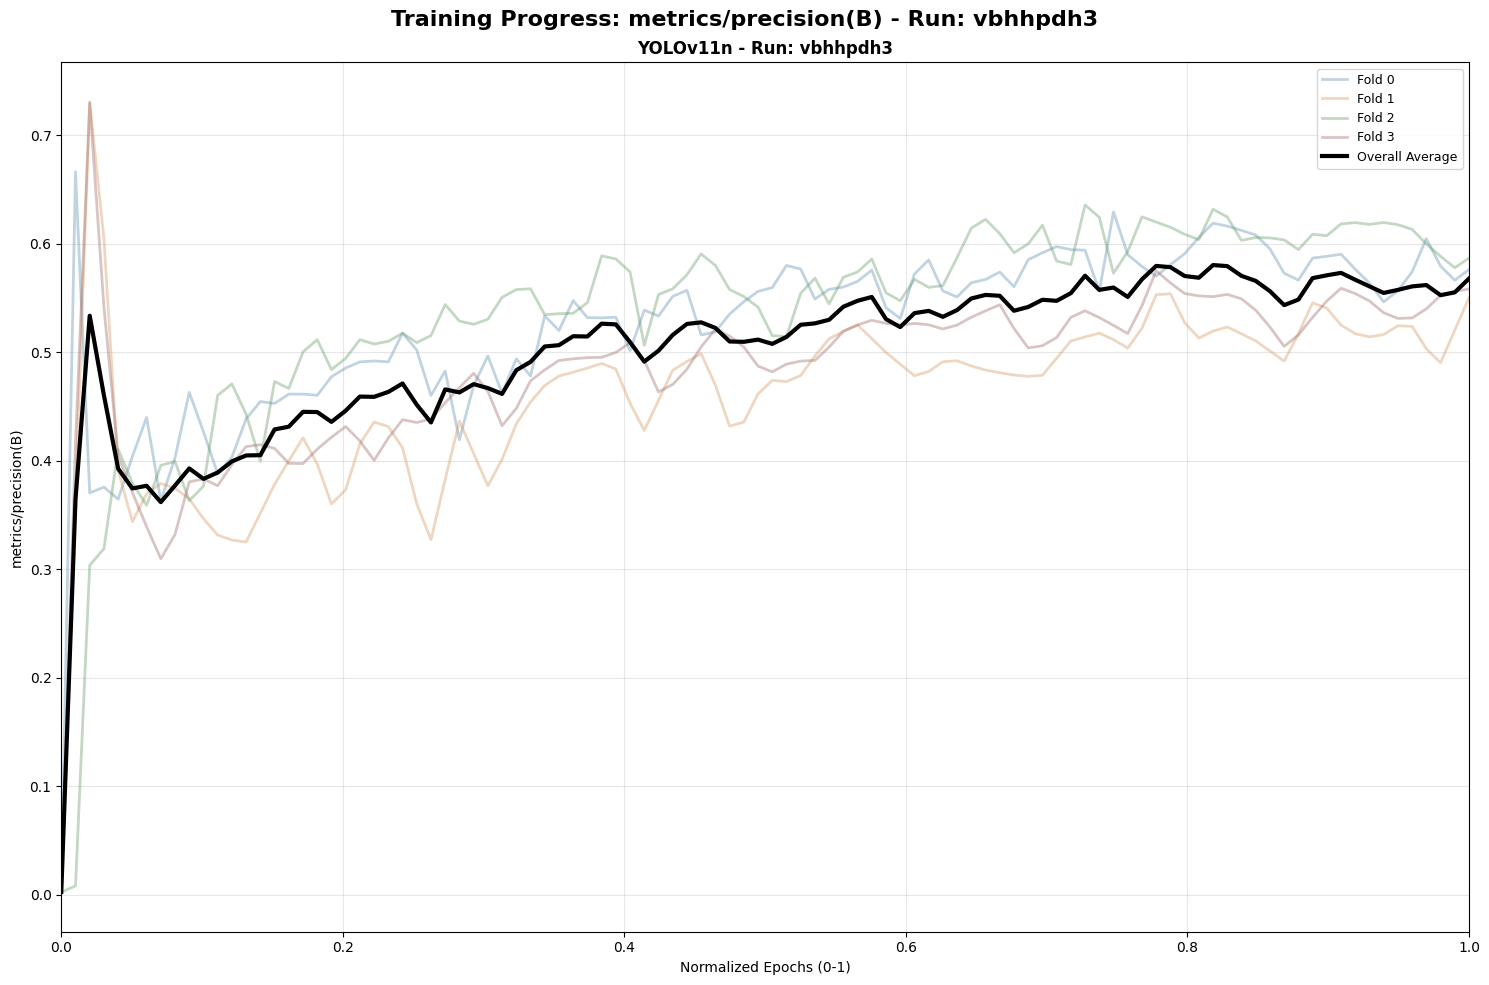

[3.7723375  3.30981881 2.92539548 2.8087272  2.72035846 2.59880346
 2.38538788 2.37739278 2.30865149 2.2565325  2.26907737 2.28014306
 2.24533795 2.20096755 2.18781412 2.14639962 2.12829187 2.12036278
 2.12687205 2.10883965 2.0870227  2.0847172  2.08213056 2.08104124
 2.07656568 2.06515253 2.05090492 1.99595932 2.03782922 2.05515578
 2.05660394 2.04268591 1.98611472 1.9737825  2.03171227 1.97990588
 1.97486977 1.95220949 1.93724604 1.91627136 1.92607972 1.94578462
 1.93570742 1.89276593 1.89342361 1.9368325  1.92646172 1.92034114
 1.90758053 1.89809172 1.89134896 1.87670485 1.86953025 1.8743603
 1.87598295 1.850745   1.86332247 1.85067303 1.84891487 1.86780432
 1.86395795 1.86574263 1.85584199 1.83285023 1.82151073 1.83323177
 1.823945   1.82883328 1.83562641 1.81325621 1.82641313 1.81496384
 1.81795364 1.80458086 1.81353533 1.81091    1.80373997 1.79740417
 1.79426015 1.78940977 1.79125159 1.79502409 1.79500831 1.79587414
 1.79464773 1.82842576 1.84543508 1.83305455 1.78757194 1.78373

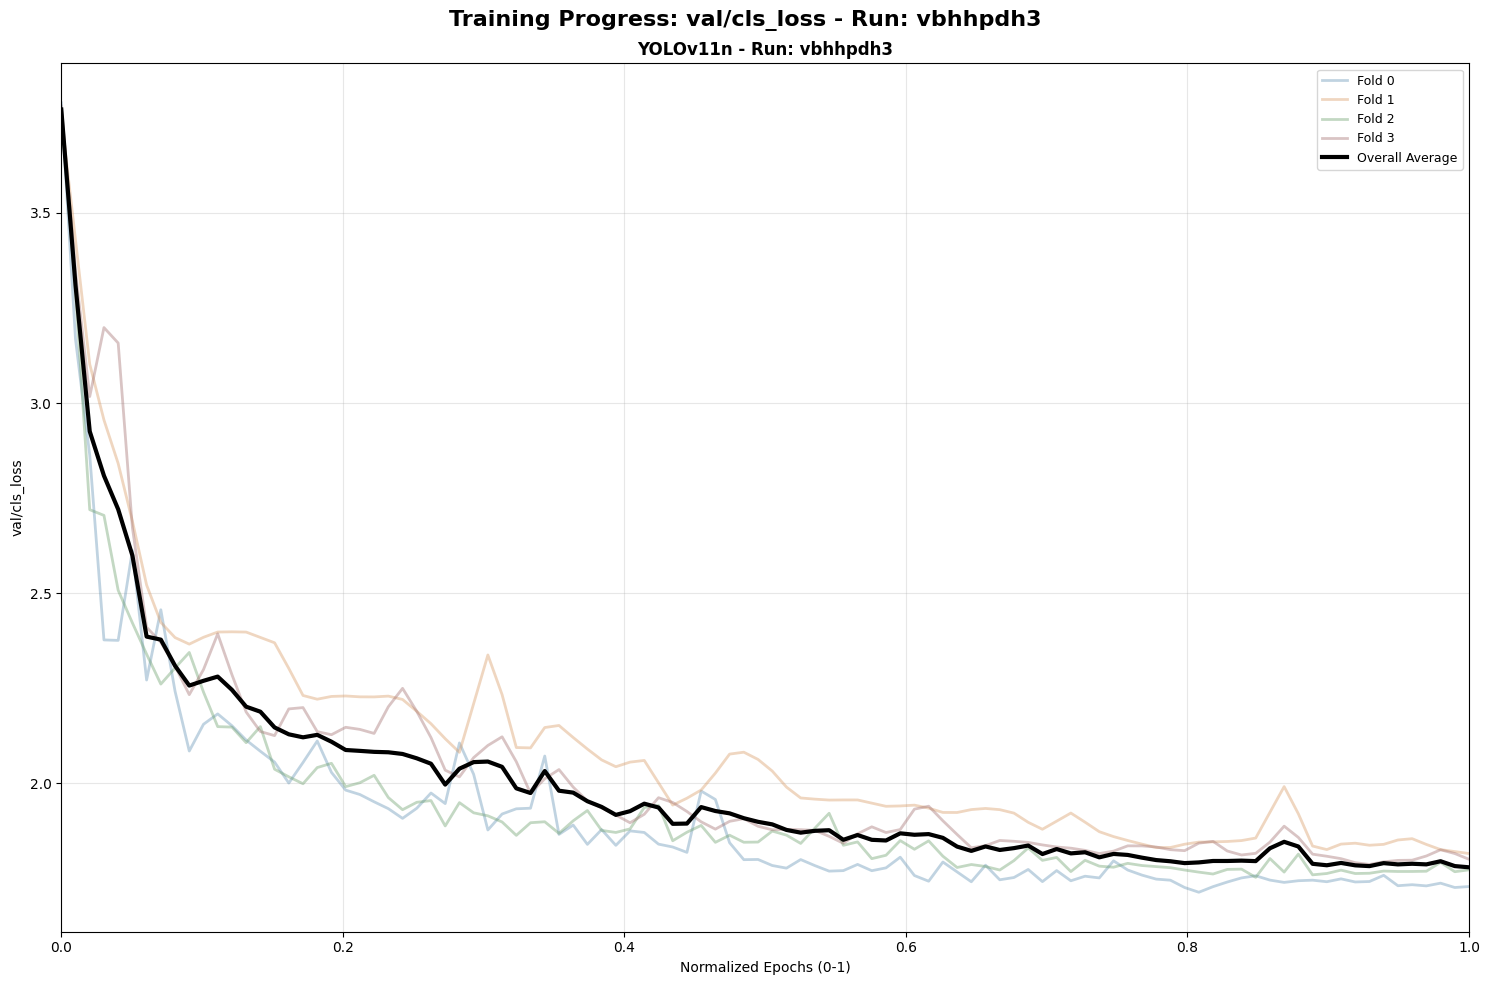

[0.0062525  0.14629235 0.19242503 0.21076871 0.23278028 0.23727947
 0.28525326 0.28635831 0.30863735 0.3240475  0.31734182 0.31884583
 0.32406167 0.3424927  0.34555654 0.36266508 0.36333889 0.36581437
 0.37733659 0.38676475 0.38326793 0.38289273 0.39075639 0.39248025
 0.39317538 0.39369071 0.39774449 0.41708341 0.40862927 0.40435088
 0.39820841 0.39209821 0.41930803 0.42543917 0.41735177 0.42774396
 0.43375682 0.44033018 0.44331313 0.44995977 0.44637235 0.43785879
 0.43809606 0.45314624 0.45137417 0.44374318 0.45020884 0.44988667
 0.45098682 0.44932359 0.44936505 0.45472568 0.46114765 0.4639425
 0.46442614 0.47698056 0.4766604  0.47962106 0.47569952 0.47297652
 0.47850477 0.47484369 0.47357386 0.47999841 0.48120167 0.48277068
 0.4837575  0.48104318 0.48214851 0.48557417 0.48560773 0.48898379
 0.49055795 0.48798225 0.48306596 0.4881178  0.49975076 0.506465
 0.5061897  0.50324371 0.50416735 0.5068025  0.50485636 0.50453119
 0.50352682 0.49590773 0.48915485 0.49378303 0.50450389 0.5063146

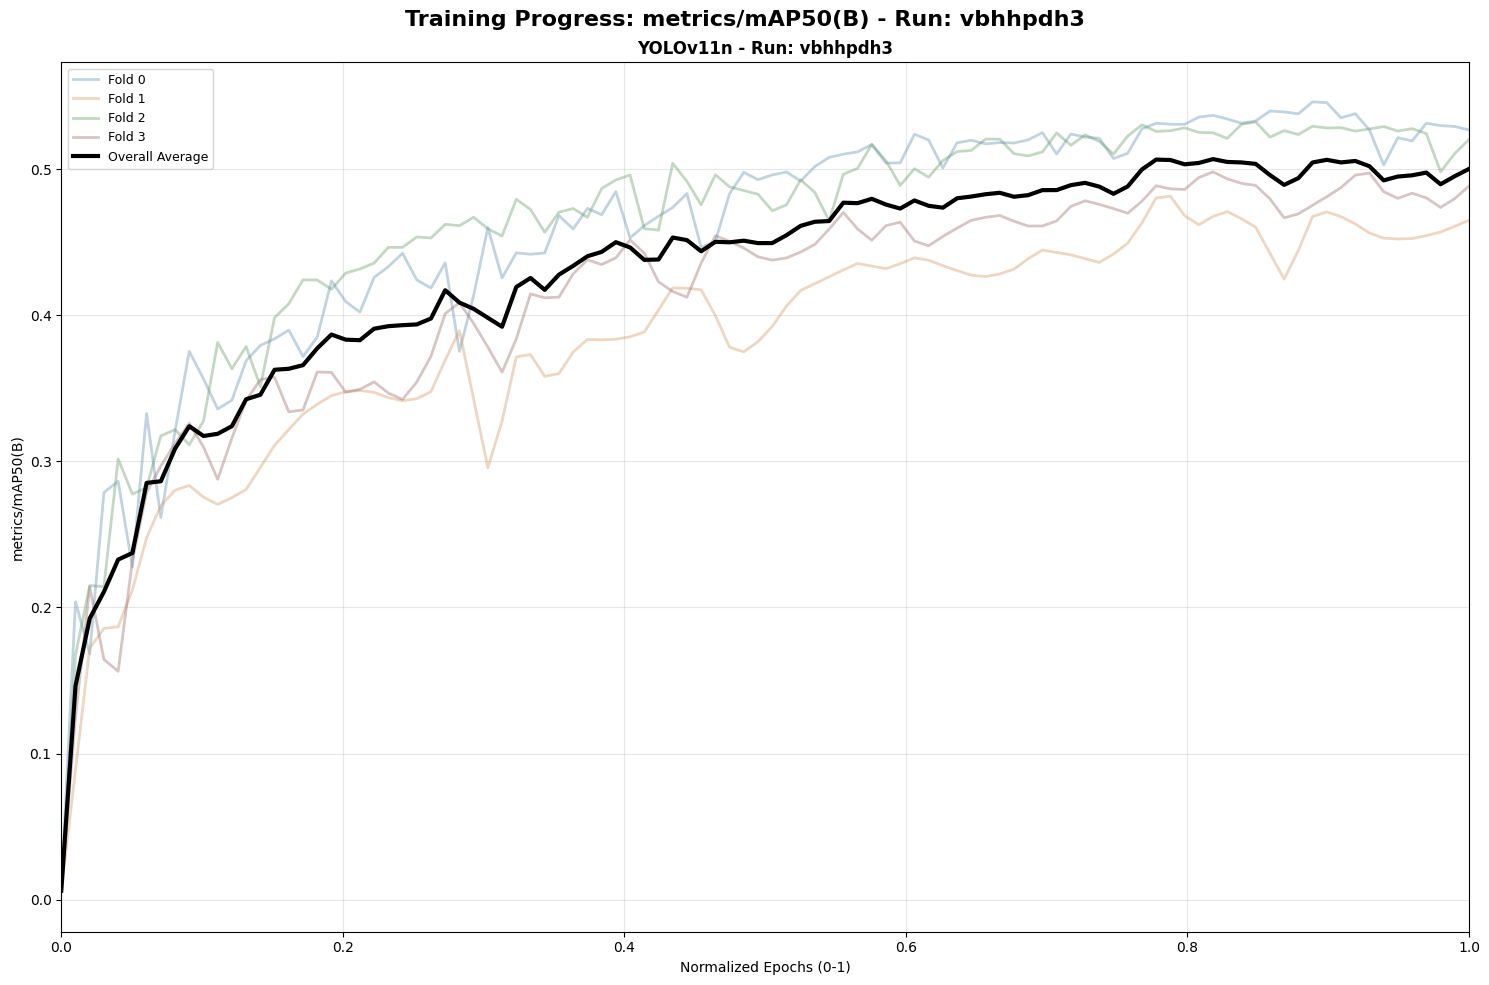

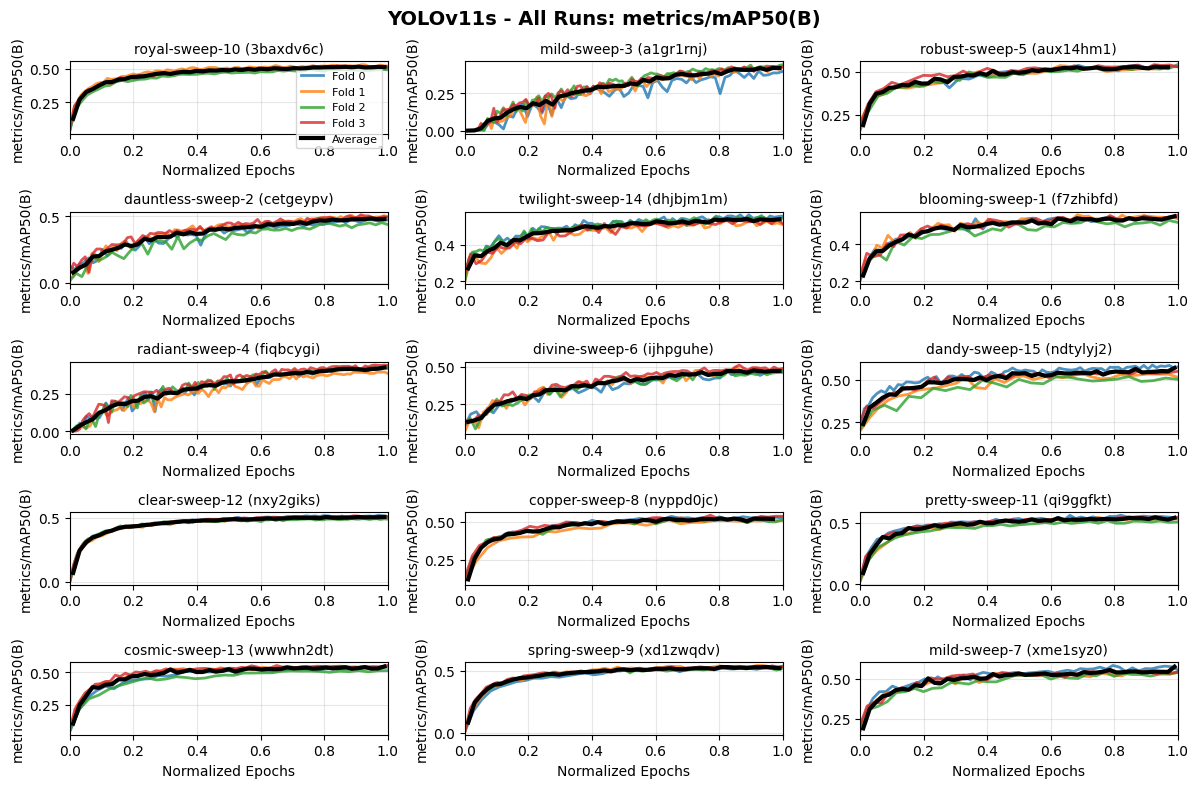

[0.215775   0.26389111 0.29858495 0.3179103  0.3368551  0.35185255
 0.36687833 0.37733929 0.38360167 0.39552909 0.39676253 0.39883861
 0.40930258 0.41648384 0.42881586 0.43872939 0.43905745 0.43822232
 0.44182818 0.44582207 0.45801697 0.46959932 0.47180222 0.47906551
 0.47856886 0.46714121 0.47126351 0.48089955 0.48779217 0.48885207
 0.48975015 0.49600247 0.50045732 0.49969083 0.49453576 0.49218568
 0.49080614 0.49391937 0.4938525  0.49428561 0.50302528 0.51053598
 0.51111644 0.50536975 0.50422056 0.5048325  0.50568106 0.51482508
 0.52355114 0.52630402 0.52752631 0.52741848 0.5230877  0.51880278
 0.51751114 0.51578028 0.51646245 0.51912576 0.51813886 0.51939169
 0.52643712 0.53221889 0.53536604 0.53335045 0.53289366 0.53231182
 0.53147917 0.53264306 0.53486758 0.53556167 0.53013578 0.53130869
 0.53075159 0.52899389 0.52692679 0.52619962 0.52454126 0.52724889
 0.5335322  0.53522162 0.53737694 0.53890318 0.53744399 0.53959215
 0.53842909 0.53856619 0.53921866 0.53550295 0.5372975  0.5367

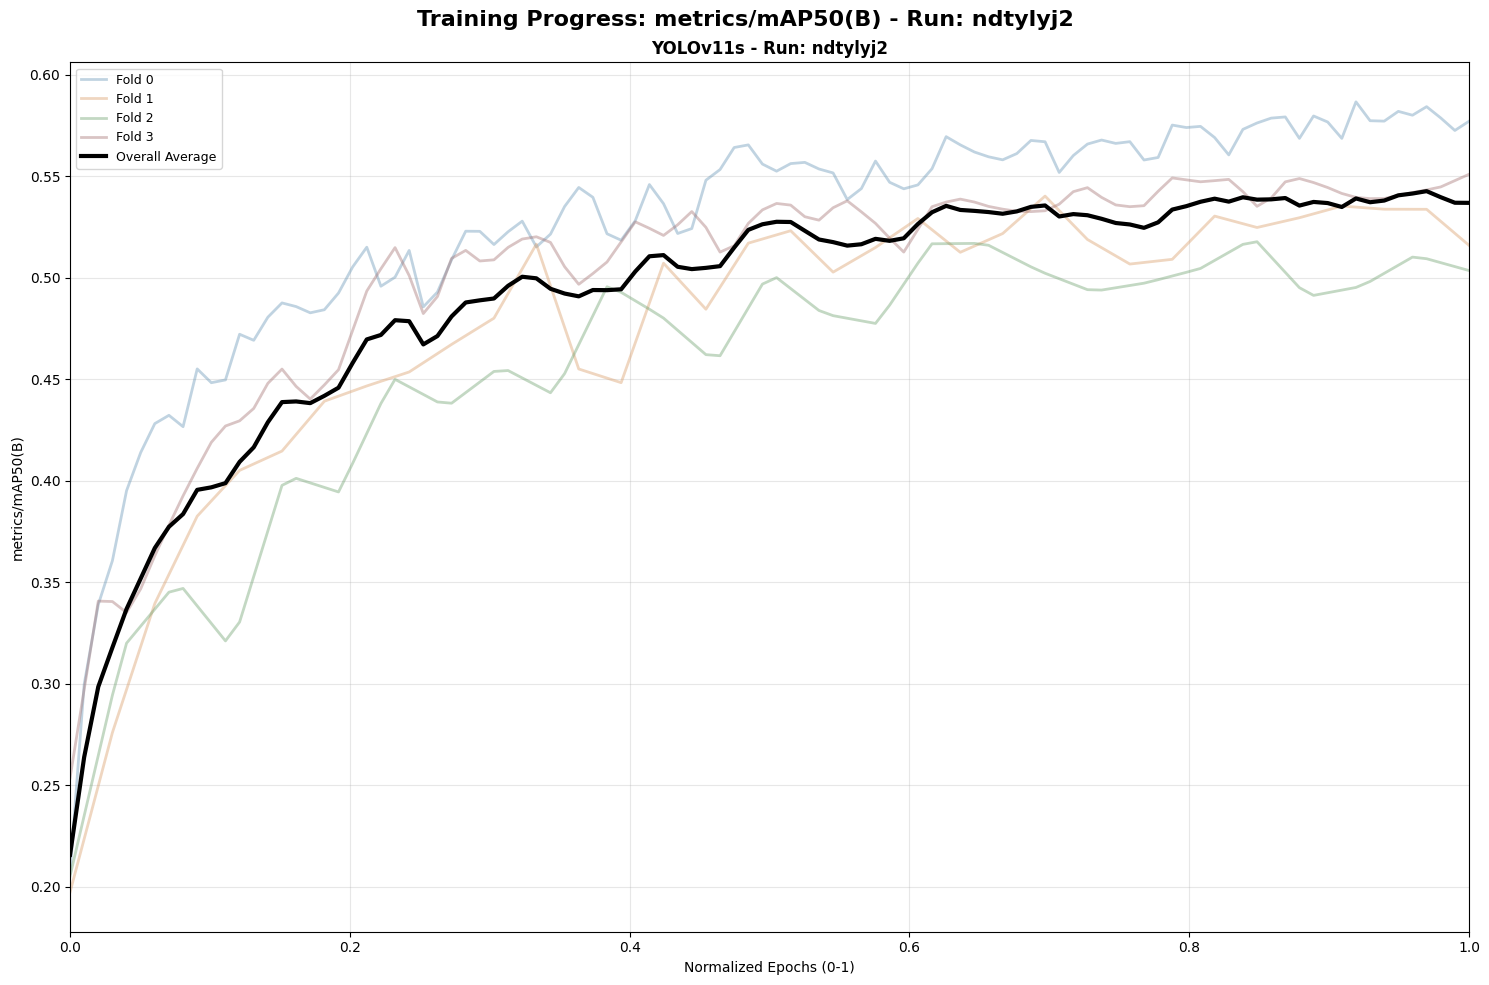

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
from scipy.interpolate import interp1d

def plot_metric_by_model(df, metric_column, run_code='ndtylyj2', figsize=(15, 10), save_path=None):
    """
    Plotta l'andamento di una metrica (es: mAP) per modello e per fold.
    
    Args:
        df (pd.DataFrame): Il DataFrame contenente i risultati.
        metric_column (str): Nome della colonna metrica da visualizzare.
        run_code (str): Facoltativo. Se specificato, filtra i dati per un solo run.
        figsize (tuple): Dimensioni della figura matplotlib.
        save_path (str): Facoltativo. Percorso dove salvare il grafico.
    """
    # Filtra i dati per il run specifico, se fornito
    if run_code:
        df = df[df['run_code'] == run_code].copy()
        title_suffix = f" - Run: {run_code}"
    else:
        title_suffix = " - All Runs"

    # Controllo esistenza metrica
    if metric_column not in df.columns:
        print(f"❌ Metrica '{metric_column}' non trovata nel DataFrame.")
        return

    # Ottieni la lista dei modelli unici
    models = sorted(df['model'].unique())
    n_models = len(models)

    # Calcola layout dei subplot
    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.atleast_2d(axes)  # Garantisce struttura 2D anche con 1 subplot

    # Definizione colori per fold
    fold_colors = ["#6393b4", "#d89963", "#6a9e6a", "#A06D6D"]
    fold_colors = [to_rgba(c, alpha=0.4) for c in fold_colors]

    for idx, model in enumerate(models):
        ax = axes[idx // cols, idx % cols]
        model_data = df[df['model'] == model]

        if model_data.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_title(f'{model} - No Data')
            continue

        # Lista per memorizzare le curve interpolate per il calcolo della media
        interpolated_curves = []
        common_x = np.linspace(0, 1, 100)

        # Ciclo sui fold (0-3)
        for fold in sorted(model_data['fold_number'].unique()):
            fold_data = model_data[model_data['fold_number'] == fold]

            if fold_data.empty:
                continue

            epochs = fold_data['epoch'].values
            values = fold_data[metric_column].values

            # Normalizza le epoche
            if len(epochs) > 1:
                norm_epochs = (epochs - epochs.min()) / (epochs.max() - epochs.min())
            else:
                norm_epochs = np.array([0.5])

            # Interpola su 100 punti
            try:
                interpolator = interp1d(norm_epochs, values, bounds_error=False, fill_value="extrapolate")
                interpolated_y = interpolator(common_x)
                interpolated_curves.append(interpolated_y)

                # Plotta curva del fold
                ax.plot(common_x, interpolated_y,
                        color=fold_colors[fold % len(fold_colors)],
                        linewidth=2, label=f"Fold {fold}")
            except Exception as e:
                print(f"⚠️ Interpolazione fallita per fold {fold} del modello {model}: {e}")

        # Calcola la curva media aggregata
        if interpolated_curves:
            mean_curve = np.mean(interpolated_curves, axis=0)
            ax.plot(common_x, mean_curve, color='black', linewidth=3, label="Overall Average", zorder=10)
            print(mean_curve)

        # Impostazioni grafiche del singolo subplot
        ax.set_title(f'{model}{title_suffix}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Normalized Epochs (0-1)', fontsize=10)
        ax.set_ylabel(metric_column, fontsize=10)
        ax.set_xlim(0, 1)
        ax.grid(True, alpha=0.3)

        # Legenda solo sul primo grafico
        if idx == 0:
            ax.legend(fontsize=9, loc='best')

    # Nascondi assi inutilizzati (in caso di subplot in più)
    for i in range(n_models, rows * cols):
        fig.delaxes(axes[i // cols, i % cols])

    # Titolo generale
    plt.suptitle(f"Training Progress: {metric_column}{title_suffix}", fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()

    # Salva o mostra il plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Plot salvato in: {save_path}")
    plt.show()


def plot_single_model_all_runs(df, model_name, metric_column, figsize=(12, 8), save_path=None):
    """
    Crea un plot per un singolo modello mostrando tutti i run separatamente.
    Ogni subplot mostra 4 fold + media per un singolo run.
    """
    
    model_data = df[df['model'] == model_name]
    
    if model_data.empty:
        print(f"❌ Nessun dato trovato per il modello {model_name}")
        return
    
    runs = sorted(model_data['run_code'].unique())
    n_runs = len(runs)
    
    # Calcola dimensioni subplot
    cols = min(3, n_runs)
    rows = (n_runs + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Normalizza axes
    if n_runs == 1:
        axes = np.array([axes])
    axes = np.atleast_2d(axes)
    
    fold_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    fold_colors_alpha = [to_rgba(color, alpha=0.7) for color in fold_colors]
    
    for idx, run in enumerate(runs):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        run_data = model_data[model_data['run_code'] == run]
        run_name = run_data['run_name'].iloc[0]
        
        # Raccogli dati per ogni fold
        fold_data = {fold_num: [] for fold_num in range(4)}
        all_data = []
        
        for fold_num in range(4):
            fold_subset = run_data[run_data['fold_number'] == fold_num]
            
            if fold_subset.empty:
                continue
            
            # Normalizza epoche
            epochs = fold_subset['epoch'].values
            if len(epochs) > 1:
                normalized_epochs = (epochs - epochs.min()) / (epochs.max() - epochs.min())
            else:
                normalized_epochs = np.array([0.5])
            
            metric_values = fold_subset[metric_column].values
            
            # Salva dati
            for norm_epoch, value in zip(normalized_epochs, metric_values):
                fold_data[fold_num].append({
                    'normalized_epoch': norm_epoch,
                    'metric_value': value
                })
                all_data.append({
                    'normalized_epoch': norm_epoch,
                    'metric_value': value
                })
        
        # Plotta ogni fold
        for fold_num in range(4):
            if not fold_data[fold_num]:
                continue
            
            fold_df = pd.DataFrame(fold_data[fold_num])
            
            # Ordina per epoca normalizzata
            fold_df = fold_df.sort_values('normalized_epoch')
            
            ax.plot(fold_df['normalized_epoch'], fold_df['metric_value'],
                   color=fold_colors_alpha[fold_num], 
                   linewidth=2, 
                   label=f'Fold {fold_num}' if idx == 0 else "",
                   alpha=0.8)
        
        # Plotta media del run
        if all_data:
            all_df = pd.DataFrame(all_data)
            
            # Aggrega in bins
            n_bins = 50
            epoch_bins = np.linspace(0, 1, n_bins)
            bin_centers = []
            bin_means = []
            
            for i in range(len(epoch_bins) - 1):
                bin_start, bin_end = epoch_bins[i], epoch_bins[i + 1]
                bin_data = all_df[
                    (all_df['normalized_epoch'] >= bin_start) & 
                    (all_df['normalized_epoch'] < bin_end)
                ]
                
                if not bin_data.empty:
                    bin_centers.append((bin_start + bin_end) / 2)
                    bin_means.append(bin_data['metric_value'].mean())
            
            if len(bin_centers) > 1:
                ax.plot(bin_centers, bin_means, 
                       color='black', 
                       linewidth=3, 
                       label='Average' if idx == 0 else "",
                       zorder=10)
        
        ax.set_title(f'{run_name} ({run})', fontsize=10)
        ax.set_xlabel('Normalized Epochs')
        ax.set_ylabel(metric_column)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        
        if idx == 0:
            ax.legend(loc='best', fontsize=8)
    
    # Nascondi subplot vuoti
    for idx in range(n_runs, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].set_visible(False)
    
    plt.suptitle(f'{model_name} - All Runs: {metric_column}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def get_available_metrics(df):
    """
    Restituisce le metriche numeriche disponibili per il plotting.
    """
    # Escludi le colonne identificative
    exclude_cols = ['model', 'run_name', 'run_code', 'fold', 'fold_number', 'epoch', 'time']
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    available_metrics = [col for col in numeric_cols if col not in exclude_cols]
    
    return available_metrics

# Plot di base - tutti i modelli con mAP50
plot_metric_by_model(df, 'metrics/precision(B)', run_code='vbhhpdh3', save_path='precision-per-epoch.png')

# Plot di training loss
plot_metric_by_model(df, 'val/cls_loss', run_code='vbhhpdh3', save_path='cls_loss-per-epoch.png')

# Plot per un run specifico
plot_metric_by_model(df, 'metrics/mAP50(B)', run_code='vbhhpdh3', save_path='map50-of-vbhhpdh.png')

# Plot dettagliato per un modello
plot_single_model_all_runs(df, 'YOLOv11s', 'metrics/mAP50(B)', save_path='map50_yolov11s.png')

# Salva il plot
plot_metric_by_model(df, 'metrics/mAP50(B)', save_path='map50_comparison.png')

In [4]:
# Definizione delle metriche di performance (target da ottimizzare)
performance_metrics = [
    'metrics/mAP50(B)',
    'metrics/mAP50-95(B)', 
    'metrics/precision(B)',
    'metrics/recall(B)'
]

# Definizione delle loss (da minimizzare)
loss_metrics = [
    'train/box_loss',
    'train/cls_loss', 
    'train/dfl_loss',
    'val/box_loss',
    'val/cls_loss',
    'val/dfl_loss'
]

# Iperparametri chiave da analizzare
key_hyperparams = [
    'lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs', 'warmup_bias_lr',
    'box', 'cls', 'dfl', 'epochs', 'batch', 'imgsz', 'augment', 'mosaic', 
    'mixup', 'copy_paste', 'degrees', 'translate', 'scale', 'shear', 'perspective',
    'hsv_h', 'hsv_s', 'hsv_v', 'flipud', 'fliplr', 'erasing', 'crop_fraction'
]

# Filtra solo le colonne presenti nel dataset
available_performance = [col for col in performance_metrics if col in df.columns]
available_loss = [col for col in loss_metrics if col in df.columns]
available_hyperparams = [col for col in key_hyperparams if col in df.columns]

print(f"Metriche di performance disponibili: {available_performance}")
print(f"Metriche di loss disponibili: {available_loss}")
print(f"Iperparametri disponibili: {len(available_hyperparams)}")

Metriche di performance disponibili: ['metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(B)', 'metrics/recall(B)']
Metriche di loss disponibili: ['train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss']
Iperparametri disponibili: 28


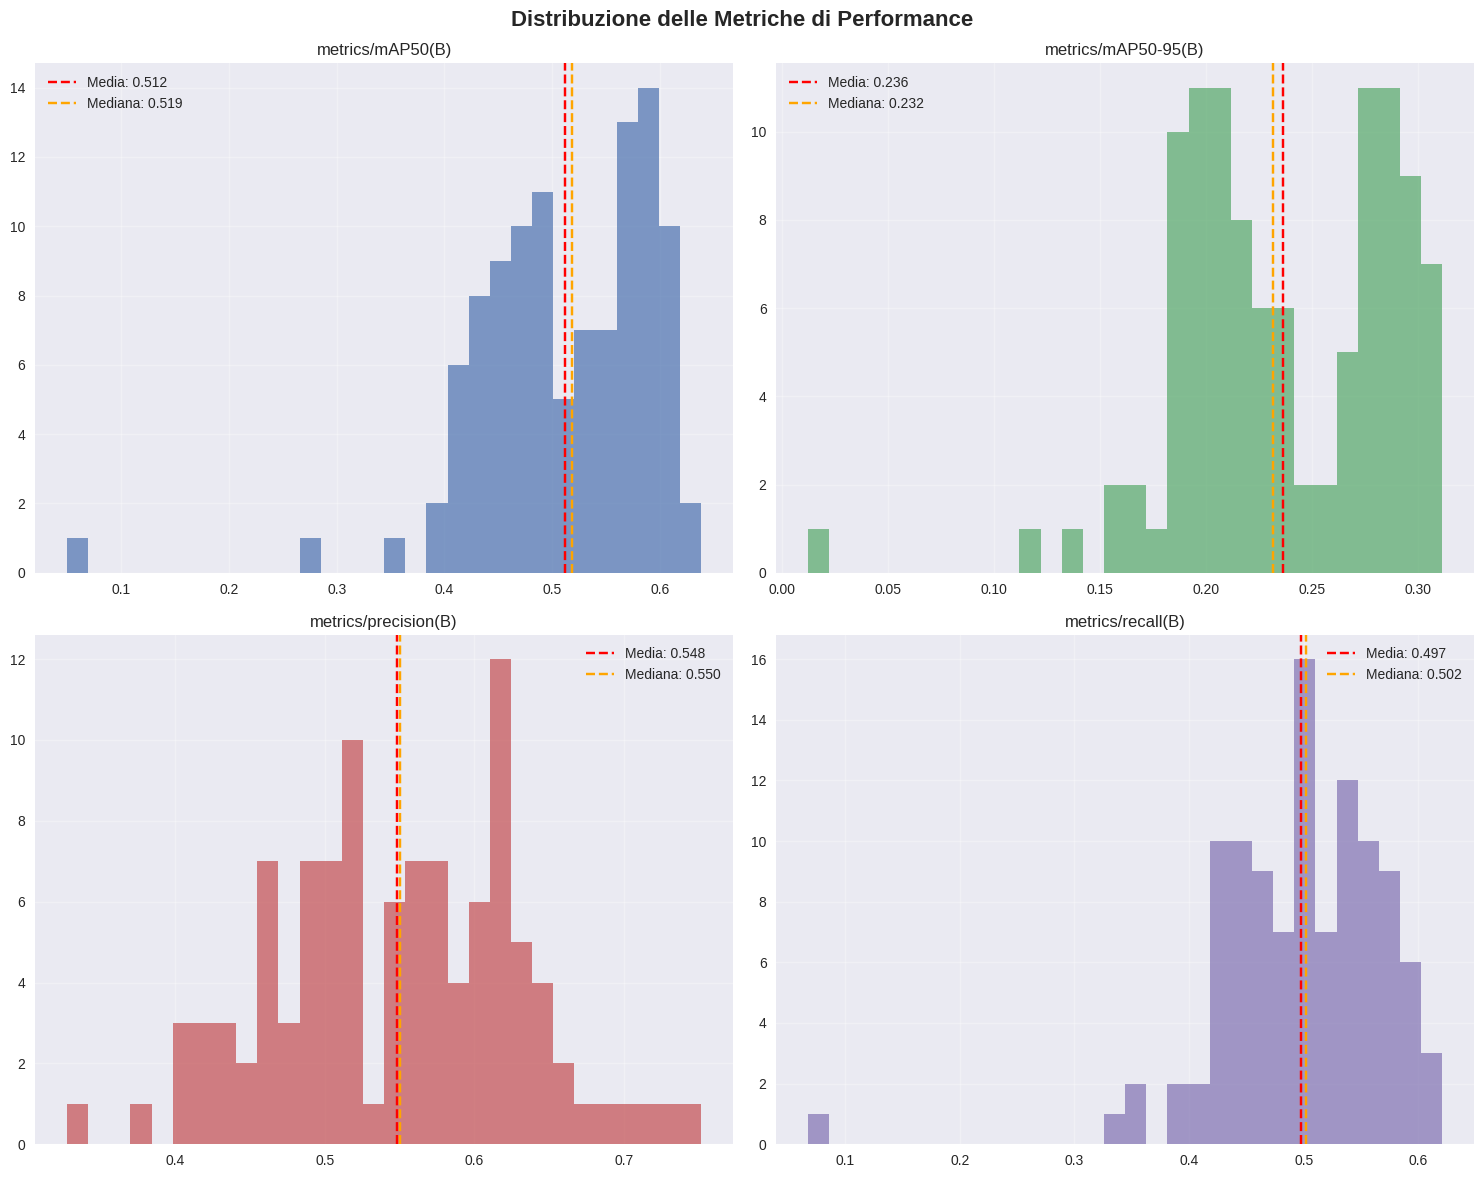

=== STATISTICHE METRICHE DI PERFORMANCE ===

metrics/mAP50(B):
  Media: 0.5118
  Mediana: 0.5188
  Std: 0.0835
  Min: 0.0497
  Max: 0.6385
  Q25: 0.4579
  Q75: 0.5773

metrics/mAP50-95(B):
  Media: 0.2362
  Mediana: 0.2316
  Std: 0.0513
  Min: 0.0121
  Max: 0.3114
  Q25: 0.1968
  Q75: 0.2822

metrics/precision(B):
  Media: 0.5484
  Mediana: 0.5504
  Std: 0.0820
  Min: 0.3274
  Max: 0.7517
  Q25: 0.4874
  Q75: 0.6149

metrics/recall(B):
  Media: 0.4973
  Mediana: 0.5017
  Std: 0.0735
  Min: 0.0675
  Max: 0.6210
  Q25: 0.4535
  Q75: 0.5493


In [5]:
# Distribuzione delle metriche principali
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribuzione delle Metriche di Performance', fontsize=16, fontweight='bold')

for i, metric in enumerate(available_performance[:4]):
    row, col = i // 2, i % 2
    
    # Istogramma
    axes[row, col].hist(df[metric].dropna(), bins=30, alpha=0.7, color=sns.color_palette()[i])
    axes[row, col].axvline(df[metric].mean(), color='red', linestyle='--', 
                          label=f'Media: {df[metric].mean():.3f}')
    axes[row, col].axvline(df[metric].median(), color='orange', linestyle='--', 
                          label=f'Mediana: {df[metric].median():.3f}')
    axes[row, col].set_title(f'{metric}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche dettagliate
print("=== STATISTICHE METRICHE DI PERFORMANCE ===")
for metric in available_performance:
    data = df[metric].dropna()
    print(f"\n{metric}:")
    print(f"  Media: {data.mean():.4f}")
    print(f"  Mediana: {data.median():.4f}")
    print(f"  Std: {data.std():.4f}")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  Q25: {data.quantile(0.25):.4f}")
    print(f"  Q75: {data.quantile(0.75):.4f}")

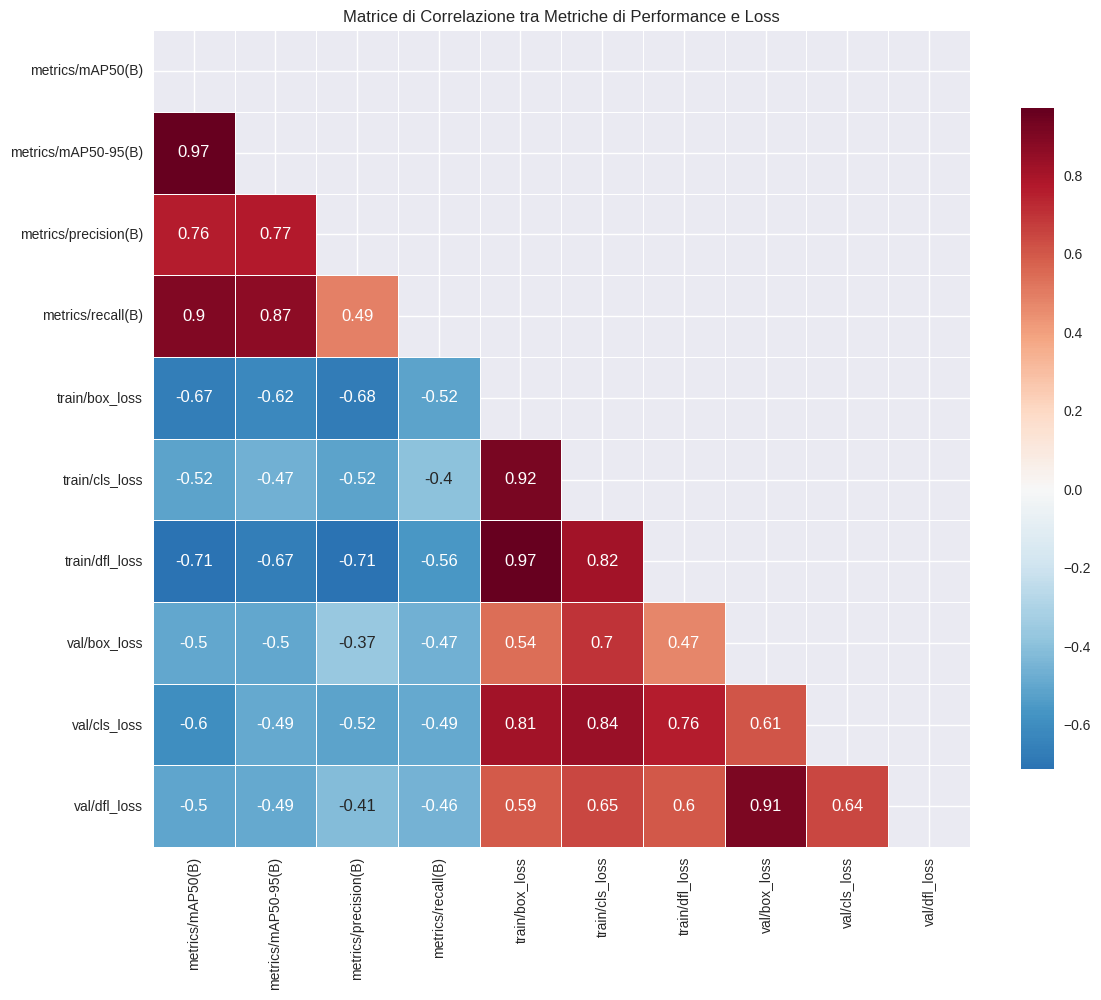

=== CORRELAZIONI PIÙ SIGNIFICATIVE ===
train/box_loss <-> train/dfl_loss: 0.971
metrics/mAP50(B) <-> metrics/mAP50-95(B): 0.967
train/box_loss <-> train/cls_loss: 0.916
val/box_loss <-> val/dfl_loss: 0.911
metrics/mAP50(B) <-> metrics/recall(B): 0.897
metrics/mAP50-95(B) <-> metrics/recall(B): 0.868
train/cls_loss <-> val/cls_loss: 0.837
train/cls_loss <-> train/dfl_loss: 0.815
train/box_loss <-> val/cls_loss: 0.813
metrics/mAP50-95(B) <-> metrics/precision(B): 0.771


In [6]:
# Matrice di correlazione tra tutte le metriche
all_metrics = available_performance + available_loss
correlation_matrix = df[all_metrics].corr()

# Heatmap delle correlazioni
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matrice di Correlazione tra Metriche di Performance e Loss')
plt.tight_layout()
plt.show()

# Trova le correlazioni più forti
print("=== CORRELAZIONI PIÙ SIGNIFICATIVE ===")
corr_pairs = []
for i in range(len(all_metrics)):
    for j in range(i+1, len(all_metrics)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:  # Soglia per correlazioni significative
            corr_pairs.append((all_metrics[i], all_metrics[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for metric1, metric2, corr in corr_pairs[:10]:
    print(f"{metric1} <-> {metric2}: {corr:.3f}")

In [7]:
# Definisci una metrica composita per ranking
def calculate_composite_score(row):
    """Calcola un punteggio composito basato su tutte le metriche"""
    score = 0
    
    # Aggiungi metriche positive (più alto = meglio)
    for metric in available_performance:
        if pd.notna(row[metric]):
            normalized_val = (row[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
            score += normalized_val
    
    # Sottrai metriche negative (più basso = meglio) 
    for metric in available_loss:
        if pd.notna(row[metric]):
            normalized_val = (row[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
            score -= normalized_val
    
    return score

df['composite_score'] = df.apply(calculate_composite_score, axis=1)

# Top 10 configurazioni
top_10 = df.nlargest(10, 'composite_score')
print("=== TOP 10 CONFIGURAZIONI ===")
print(top_10[['composite_score'] + available_performance + available_loss].round(4))

# Analisi dei top performer
print("\n=== CARATTERISTICHE DEI TOP PERFORMER ===")
top_5 = df.nlargest(5, 'composite_score')
for param in available_hyperparams[:10]:  # Primi 10 iperparametri
    if param in df.columns:
        print(f"\n{param}:")
        print(f"  Top 5 - Media: {top_5[param].mean():.4f}, Std: {top_5[param].std():.4f}")
        print(f"  Tutti - Media: {df[param].mean():.4f}, Std: {df[param].std():.4f}")

=== TOP 10 CONFIGURAZIONI ===
    composite_score  metrics/mAP50(B)  metrics/mAP50-95(B)  \
33           3.4885            0.6145               0.3114   
31           3.3557            0.6385               0.3086   
26           3.2790            0.6324               0.3049   
1            3.2679            0.6083               0.3045   
13           3.0746            0.5821               0.2899   
40           3.0691            0.5964               0.2846   
47           3.0562            0.6049               0.3001   
36           3.0485            0.6068               0.3082   
12           3.0372            0.6023               0.2765   
53           3.0170            0.5853               0.2842   

    metrics/precision(B)  metrics/recall(B)  train/box_loss  train/cls_loss  \
33                0.6610             0.6059          1.2910          0.9111   
31                0.7158             0.5336          1.3142          0.8771   
26                0.6726             0.5650       

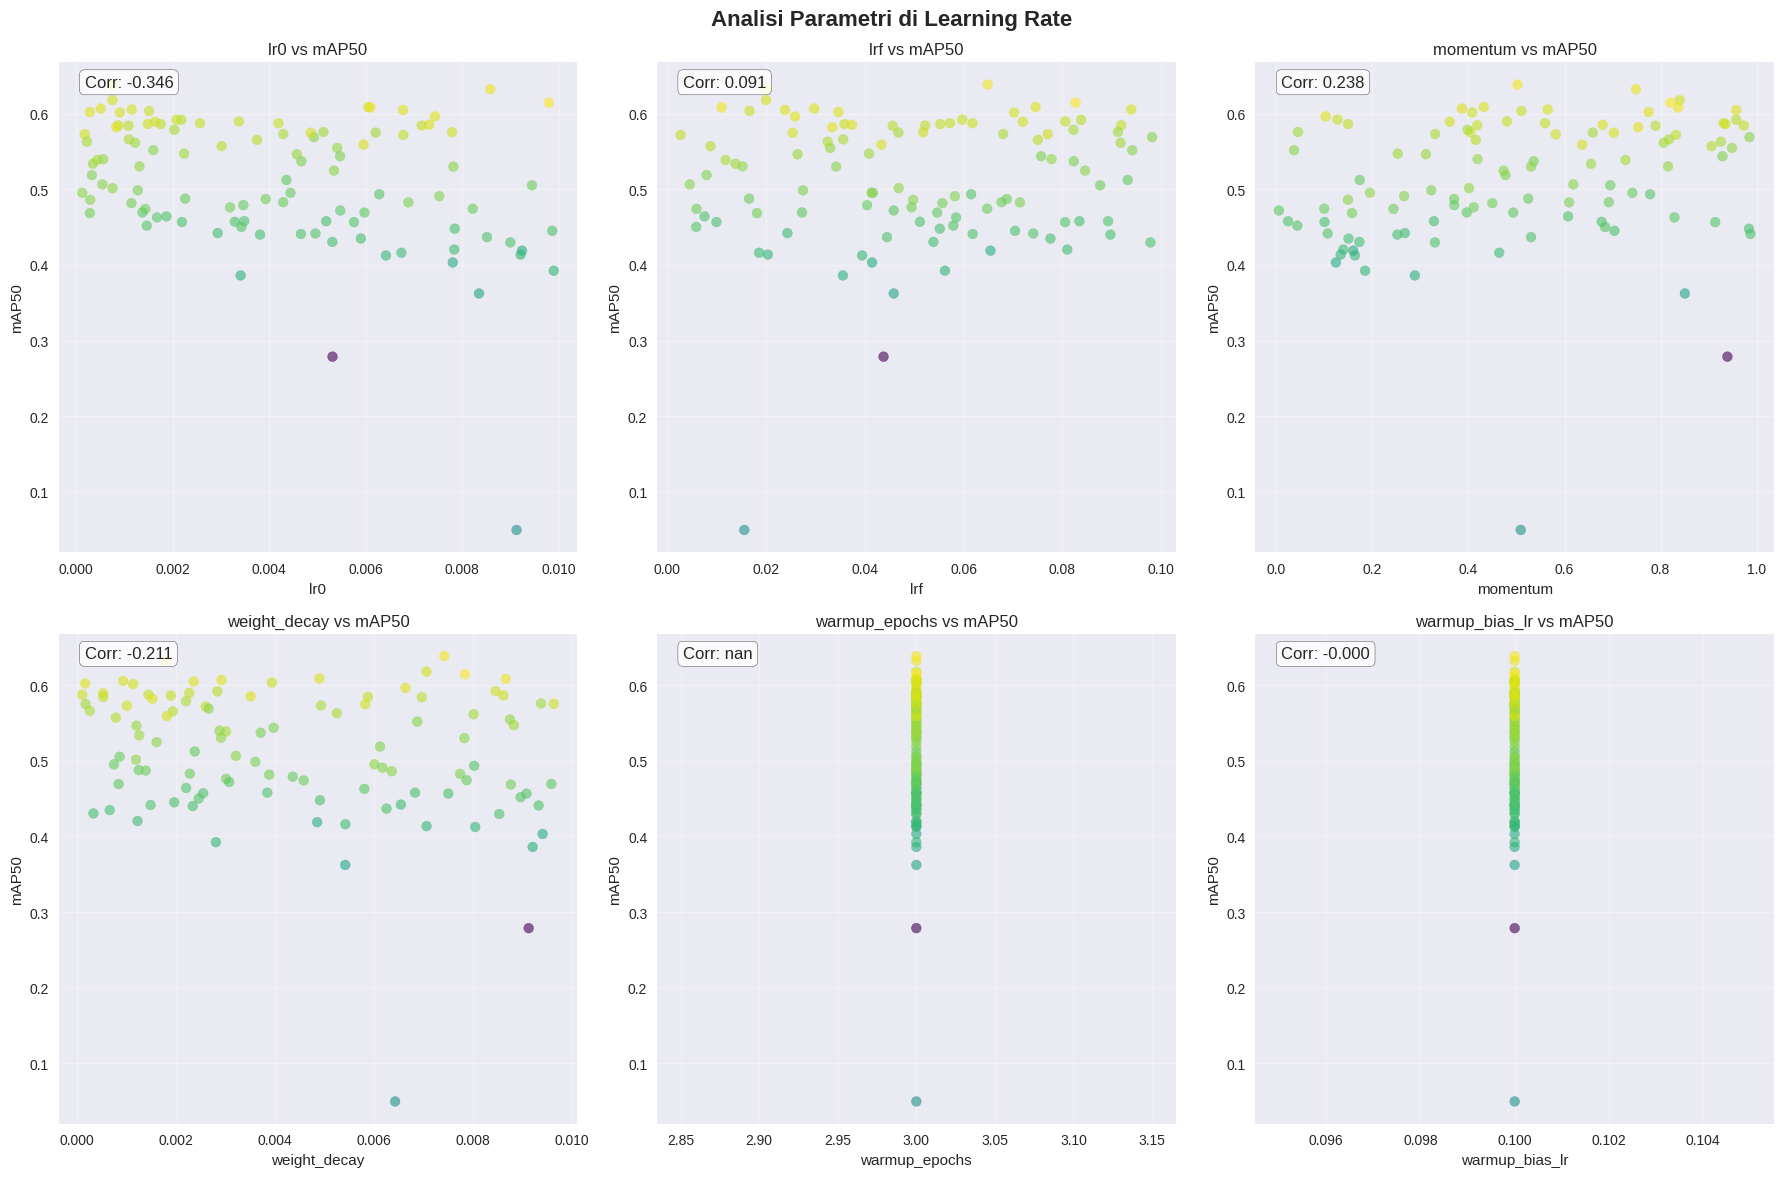

In [8]:
# Analisi dei learning rate parameters
lr_params = ['lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs', 'warmup_bias_lr']
available_lr_params = [p for p in lr_params if p in df.columns]

if available_lr_params:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Analisi Parametri di Learning Rate', fontsize=16, fontweight='bold')
    
    for i, param in enumerate(available_lr_params[:6]):
        row, col = i // 3, i % 3
        
        # Scatter plot con mAP50
        if 'metrics/mAP50(B)' in df.columns:
            scatter = axes[row, col].scatter(df[param], df['metrics/mAP50(B)'], 
                                           alpha=0.6, c=df['composite_score'], 
                                           cmap='viridis', s=50)
            axes[row, col].set_xlabel(param)
            axes[row, col].set_ylabel('mAP50')
            axes[row, col].set_title(f'{param} vs mAP50')
            axes[row, col].grid(True, alpha=0.3)
            
            # Calcola correlazione
            corr = df[param].corr(df['metrics/mAP50(B)'])
            axes[row, col].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                               transform=axes[row, col].transAxes, 
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

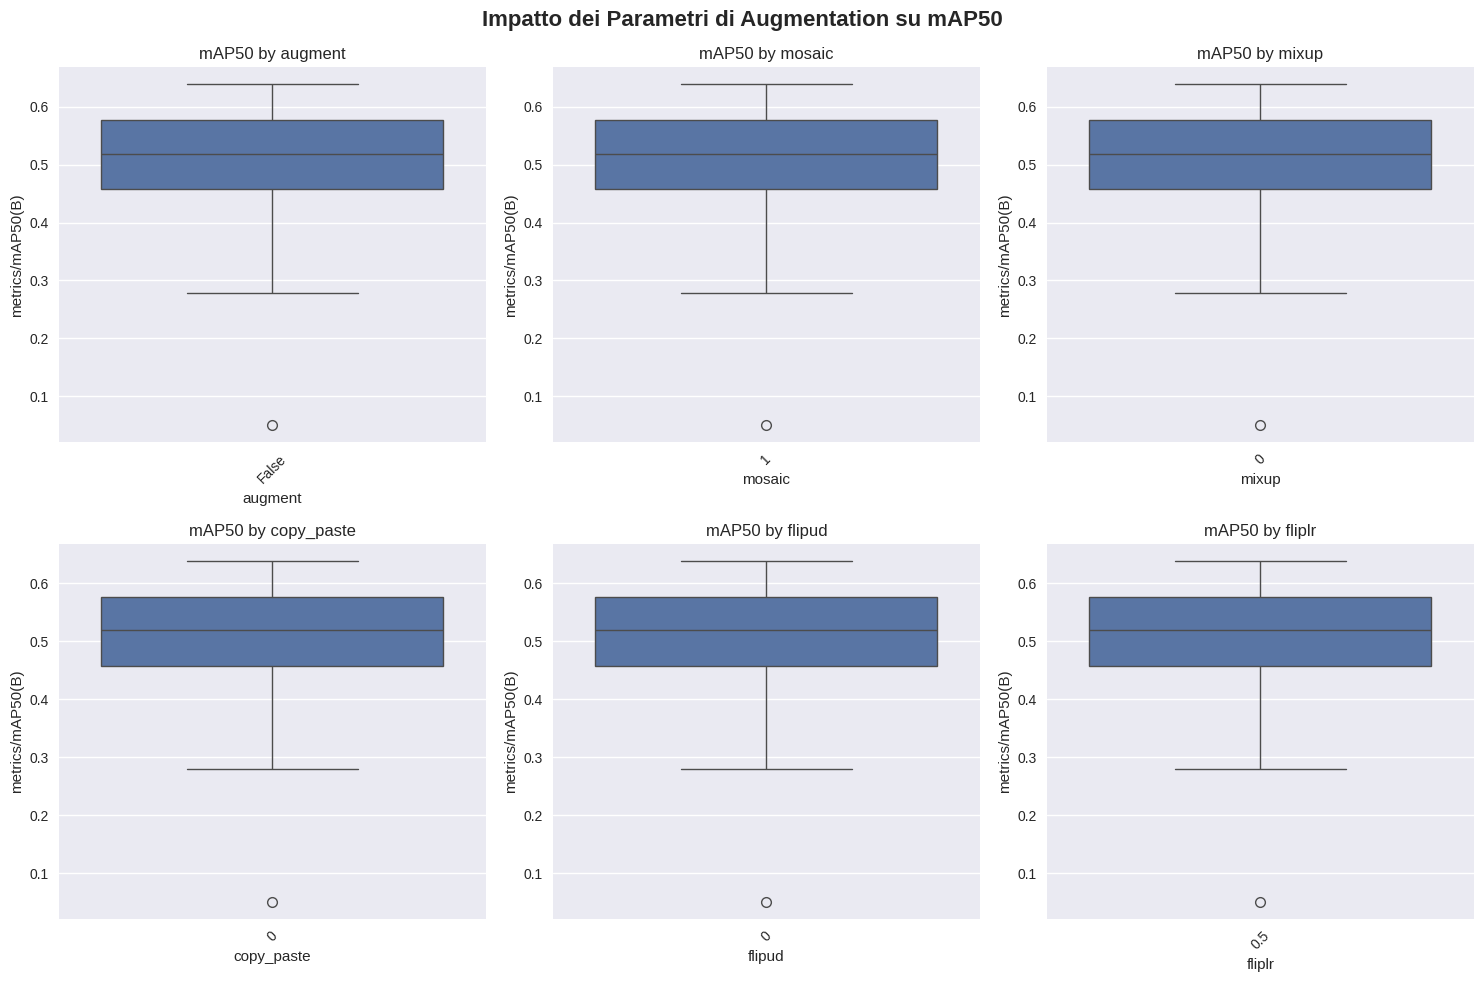

=== CORRELAZIONI PARAMETRI AUGMENTATION CON PERFORMANCE ===
degrees <-> mAP50: nan
translate <-> mAP50: -0.000
scale <-> mAP50: nan
shear <-> mAP50: nan
perspective <-> mAP50: nan
hsv_h <-> mAP50: 0.000
hsv_s <-> mAP50: 0.000
hsv_v <-> mAP50: -0.000
erasing <-> mAP50: -0.000
crop_fraction <-> mAP50: nan


In [9]:
# Parametri di data augmentation
aug_params = ['augment', 'mosaic', 'mixup', 'copy_paste', 'degrees', 'translate', 
              'scale', 'shear', 'perspective', 'hsv_h', 'hsv_s', 'hsv_v', 
              'flipud', 'fliplr', 'erasing', 'crop_fraction']
available_aug_params = [p for p in aug_params if p in df.columns]

# Box plot per parametri categorici di augmentation
categorical_aug = ['augment', 'mosaic', 'mixup', 'copy_paste', 'flipud', 'fliplr']
available_cat_aug = [p for p in categorical_aug if p in df.columns]

if available_cat_aug and 'metrics/mAP50(B)' in df.columns:
    n_plots = len(available_cat_aug)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Impatto dei Parametri di Augmentation su mAP50', fontsize=16, fontweight='bold')
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, param in enumerate(available_cat_aug):
        row, col = i // n_cols, i % n_cols
        
        try:
            sns.boxplot(data=df, x=param, y='metrics/mAP50(B)', ax=axes[row, col])
            axes[row, col].set_title(f'mAP50 by {param}')
            axes[row, col].tick_params(axis='x', rotation=45)
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'Errore: {param}', 
                               ha='center', va='center', transform=axes[row, col].transAxes)
    
    # Nascondi subplot vuoti
    for i in range(n_plots, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Analisi dei parametri numerici di augmentation
numeric_aug = ['degrees', 'translate', 'scale', 'shear', 'perspective', 
               'hsv_h', 'hsv_s', 'hsv_v', 'erasing', 'crop_fraction']
available_num_aug = [p for p in numeric_aug if p in df.columns]

print("=== CORRELAZIONI PARAMETRI AUGMENTATION CON PERFORMANCE ===")
for param in available_num_aug:
    if 'metrics/mAP50(B)' in df.columns:
        corr = df[param].corr(df['metrics/mAP50(B)'])
        print(f"{param} <-> mAP50: {corr:.3f}")

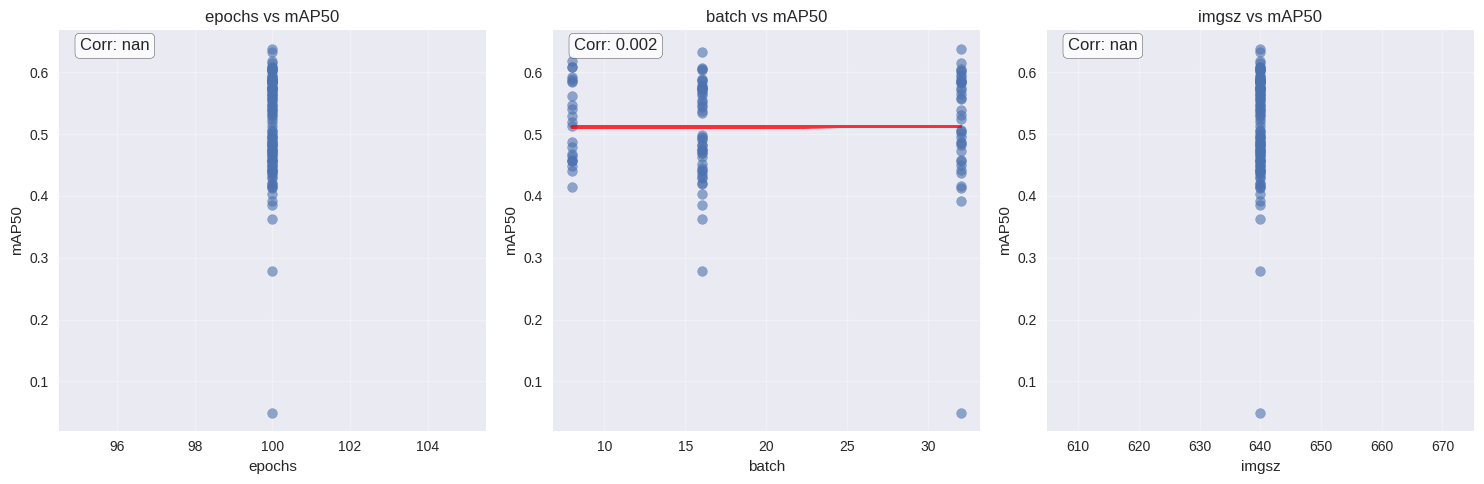

=== TRADE-OFF PERFORMANCE vs COMPLESSITÀ ===
model/GFLOPs <-> mAP50: 0.082
model/parameters <-> mAP50: -0.082
model/speed_PyTorch(ms) <-> mAP50: -0.184


In [10]:
# Parametri di architettura e training
model_params = ['epochs', 'batch', 'imgsz']
available_model_params = [p for p in model_params if p in df.columns]

if available_model_params:
    fig, axes = plt.subplots(1, len(available_model_params), figsize=(5*len(available_model_params), 5))
    if len(available_model_params) == 1:
        axes = [axes]
    
    for i, param in enumerate(available_model_params):
        if 'metrics/mAP50(B)' in df.columns:
            # Scatter plot con trend line
            x = df[param].dropna()
            y = df['metrics/mAP50(B)'][df[param].notna()]
            
            axes[i].scatter(x, y, alpha=0.6, s=50)
            
            # Aggiungi trend line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            axes[i].plot(x, p(x), "r--", alpha=0.8)
            
            axes[i].set_xlabel(param)
            axes[i].set_ylabel('mAP50')
            axes[i].set_title(f'{param} vs mAP50')
            axes[i].grid(True, alpha=0.3)
            
            # Correlazione
            corr = df[param].corr(df['metrics/mAP50(B)'])
            axes[i].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                        transform=axes[i].transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Analisi delle dimensioni del modello e velocità
model_metrics = ['model/GFLOPs', 'model/parameters', 'model/speed_PyTorch(ms)']
available_model_metrics = [m for m in model_metrics if m in df.columns]

if available_model_metrics:
    print("=== TRADE-OFF PERFORMANCE vs COMPLESSITÀ ===")
    for metric in available_model_metrics:
        if 'metrics/mAP50(B)' in df.columns:
            corr = df[metric].corr(df['metrics/mAP50(B)'])
            print(f"{metric} <-> mAP50: {corr:.3f}")

=== ANALISI DEI CLUSTER ===

Cluster 0 (n=15):
  mAP50 medio: 0.5255
  mAP50 std: 0.0596
  Composite Score medio: 2.1245
  Caratteristiche principali:
    lr0: 0.002 (vs globale: 0.004)
    lrf: 0.067 (vs globale: 0.051)
    momentum: 0.272 (vs globale: 0.508)
    weight_decay: 0.004 (vs globale: 0.004)

Cluster 1 (n=17):
  mAP50 medio: 0.5559
  mAP50 std: 0.0551
  Composite Score medio: 2.5432
  Caratteristiche principali:
    lr0: 0.004 (vs globale: 0.004)
    lrf: 0.026 (vs globale: 0.051)
    momentum: 0.781 (vs globale: 0.508)
    weight_decay: 0.003 (vs globale: 0.004)

Cluster 2 (n=25):
  mAP50 medio: 0.4610
  mAP50 std: 0.1208
  Composite Score medio: 1.2858
  Caratteristiche principali:
    lr0: 0.007 (vs globale: 0.004)
    weight_decay: 0.007 (vs globale: 0.004)

Cluster 3 (n=21):
  mAP50 medio: 0.5078
  mAP50 std: 0.0624
  Composite Score medio: 1.8367
  Caratteristiche principali:
    lr0: 0.002 (vs globale: 0.004)
    lrf: 0.027 (vs globale: 0.051)
    momentum: 0.443 (vs

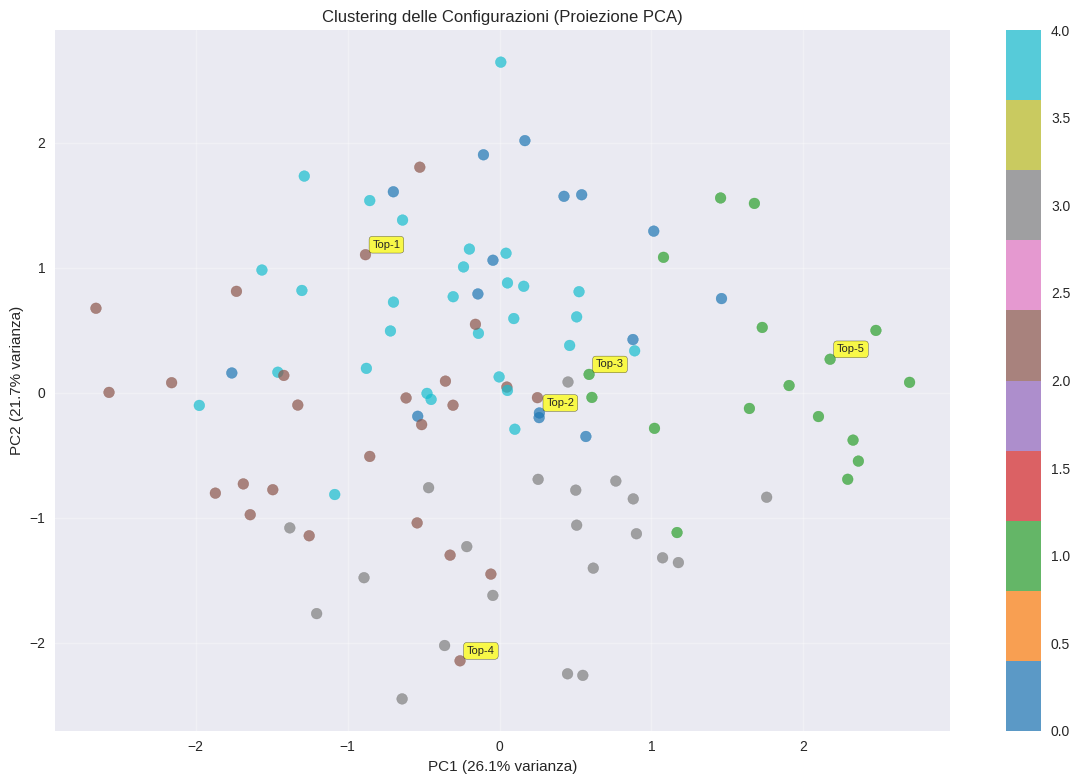

In [11]:
# Prepara i dati per clustering
cluster_features = available_hyperparams[:15]  # Usa i primi 15 iperparametri
cluster_data = df[cluster_features].fillna(df[cluster_features].mean())

# Standardizza i dati
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Applica K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Analizza i cluster
print("=== ANALISI DEI CLUSTER ===")
for cluster_id in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    if 'metrics/mAP50(B)' in df.columns:
        print(f"  mAP50 medio: {cluster_data['metrics/mAP50(B)'].mean():.4f}")
        print(f"  mAP50 std: {cluster_data['metrics/mAP50(B)'].std():.4f}")
    
    print(f"  Composite Score medio: {cluster_data['composite_score'].mean():.4f}")
    
    # Caratteristiche distintive del cluster
    print("  Caratteristiche principali:")
    for param in cluster_features[:5]:
        mean_val = cluster_data[param].mean()
        global_mean = df[param].mean()
        if abs(mean_val - global_mean) > 0.1 * df[param].std():
            print(f"    {param}: {mean_val:.3f} (vs globale: {global_mean:.3f})")

# Visualizza i cluster con PCA
pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(cluster_data_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_pca[:, 0], cluster_pca[:, 1], 
                     c=df['cluster'], cmap='tab10', alpha=0.7, s=60)
plt.colorbar(scatter)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.title('Clustering delle Configurazioni (Proiezione PCA)')
plt.grid(True, alpha=0.3)

# Aggiungi etichette per i top performer
top_5_indices = df.nlargest(5, 'composite_score').index
for idx in top_5_indices:
    plt.annotate(f'Top-{list(top_5_indices).index(idx)+1}', 
                xy=(cluster_pca[idx, 0], cluster_pca[idx, 1]),
                xytext=(5, 5), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                fontsize=8)

plt.tight_layout()
plt.show()

0.0098990984374759
0.0981443226207957
0.987281463463806
0.0096332925575265
3
0.1
7.5
0.5
1.5
100
32
640
False
1
0
0
0
0.1
0.5
0
0
0.015
0.7
0.4
0
0.5
0.4
1


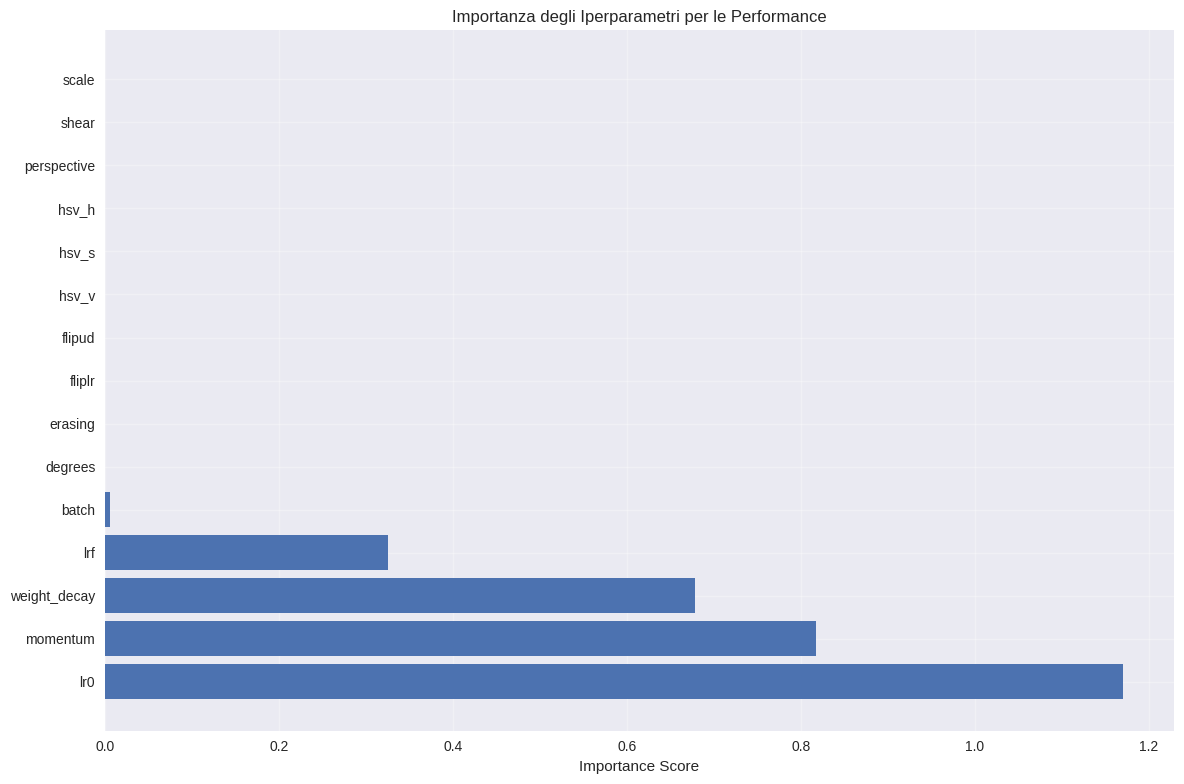

=== RANKING IMPORTANZA IPERPARAMETRI ===
 1. lr0: 1.1702
 2. momentum: 0.8177
 3. weight_decay: 0.6783
 4. lrf: 0.3258
 5. batch: 0.0061
 6. degrees: 0.0000
 7. erasing: 0.0000
 8. fliplr: 0.0000
 9. flipud: 0.0000
10. hsv_v: 0.0000


In [14]:
# Calcola l'importanza degli iperparametri basata sulla varianza delle performance
def calculate_hyperparameter_importance():
    importance_scores = {}
    
    for param in available_hyperparams:
        if param in df.columns and 'metrics/mAP50(B)' in df.columns:
            # Calcola la correlazione assoluta
            corr = abs(df[param].corr(df['metrics/mAP50(B)']))
            
            # Calcola l'effetto della variazione del parametro
            param_std = df[param].std()
            print(df[param].max())
            param_range = df[param].max() - df[param].min() if df[param].max() and df[param].min() else 0
            
            # Score combinato
            importance_scores[param] = corr * (param_range / param_std) if param_std > 0 else 0
    
    return importance_scores

importance = calculate_hyperparameter_importance()
importance_df = pd.DataFrame(list(importance.items()), 
                           columns=['Parameter', 'Importance']).sort_values('Importance', ascending=False)

# Visualizza l'importanza degli iperparametri
plt.figure(figsize=(12, 8))
top_params = importance_df.head(15)
plt.barh(range(len(top_params)), top_params['Importance'])
plt.yticks(range(len(top_params)), top_params['Parameter'])
plt.xlabel('Importance Score')
plt.title('Importanza degli Iperparametri per le Performance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=== RANKING IMPORTANZA IPERPARAMETRI ===")
for i, (param, score) in enumerate(importance_df.head(10).values):
    print(f"{i+1:2d}. {param}: {score:.4f}")

In [15]:
# Identifica la configurazione ottimale
best_config = df.loc[df['composite_score'].idxmax()]

print("="*60)
print("🎯 CONFIGURAZIONE OTTIMALE IDENTIFICATA")
print("="*60)

print(f"Composite Score: {best_config['composite_score']:.4f}")
print(f"Run ID: {best_config.get('run_id', 'N/A')}")

print("\n📊 METRICHE DI PERFORMANCE:")
for metric in available_performance:
    print(f"  {metric}: {best_config[metric]:.4f}")

print("\n📉 LOSS VALUES:")
for metric in available_loss:
    print(f"  {metric}: {best_config[metric]:.4f}")

print("\n⚙️ IPERPARAMETRI CHIAVE:")
important_params = importance_df.head(10)['Parameter'].values
for param in important_params:
    if param in df.columns:
        print(f"  {param}: {best_config[param]}")

# Confronta con la media
print("\n" + "="*60)
print("📈 CONFRONTO CON LA MEDIA DEL DATASET")
print("="*60)

for metric in available_performance:
    improvement = ((best_config[metric] - df[metric].mean()) / df[metric].mean()) * 100
    print(f"{metric}: {improvement:+.2f}% rispetto alla media")

# Analisi di robustezza
print("\n" + "="*60)
print("🔍 ANALISI DI ROBUSTEZZA")
print("="*60)

# Trova configurazioni simili alla migliore
similarity_threshold = 0.8
similar_configs = []

for idx, row in df.iterrows():
    if idx != df['composite_score'].idxmax():
        similarity = 0
        count = 0
        for param in important_params[:5]:  # Usa i 5 parametri più importanti
            if param in df.columns:
                if abs(row[param] - best_config[param]) / (df[param].std() + 1e-6) < 1:
                    similarity += 1
                count += 1
        
        if count > 0 and similarity / count >= similarity_threshold:
            similar_configs.append((idx, row['composite_score']))

if similar_configs:
    print(f"Trovate {len(similar_configs)} configurazioni simili con performance comparabili")
    similar_scores = [score for _, score in similar_configs]
    print(f"Score medio configurazioni simili: {np.mean(similar_scores):.4f}")
    print(f"Deviazione standard: {np.std(similar_scores):.4f}")
else:
    print("⚠️  La configurazione ottimale è unica - potrebbe essere overfitting")

# Raccomandazioni finali
print("\n" + "="*60)
print("💡 RACCOMANDAZIONI FINALI")
print("="*60)

print("1. CONFIGURAZIONE RACCOMANDATA:")
print("   Usa la configurazione ottimale identificata sopra")

print("\n2. PARAMETRI CRITICI DA MONITORARE:")
for i, param in enumerate(important_params[:5]):
    print(f"   {i+1}. {param}")

print("\n3. SUGGERIMENTI PER ULTERIORI ESPERIMENTI:")
print("   - Fai fine-tuning attorno ai valori ottimali identificati")
print("   - Testa combinazioni degli iperparametri più importanti")
print("   - Considera l'early stopping se non già implementato")

if len(similar_configs) < 3:
    print("   - Aumenta il numero di esperimenti per validare la robustezza")

print("\n4. TRADE-OFF DA CONSIDERARE:")
if 'model/speed_PyTorch(ms)' in df.columns:
    speed_corr = df['model/speed_PyTorch(ms)'].corr(df['metrics/mAP50(B)'])
    if speed_corr > 0.3:
        print("   - Performance vs Velocità di inferenza (correlazione positiva)")
    elif speed_corr < -0.3:
        print("   - Performance vs Velocità di inferenza (correlazione negativa)")

if 'model/parameters' in df.columns:
    param_corr = df['model/parameters'].corr(df['metrics/mAP50(B)'])
    if param_corr > 0.3:
        print("   - Performance vs Dimensione modello (più parametri = migliori performance)")
    elif param_corr < -0.3:
        print("   - Performance vs Dimensione modello (meno parametri = migliori performance)")

print("\n" + "="*60)
print("✅ ANALISI COMPLETATA")
print("="*60)

🎯 CONFIGURAZIONE OTTIMALE IDENTIFICATA
Composite Score: 3.4885
Run ID: 1ts1d6um

📊 METRICHE DI PERFORMANCE:
  metrics/mAP50(B): 0.6145
  metrics/mAP50-95(B): 0.3114
  metrics/precision(B): 0.6610
  metrics/recall(B): 0.6059

📉 LOSS VALUES:
  train/box_loss: 1.2910
  train/cls_loss: 0.9111
  train/dfl_loss: 1.1098
  val/box_loss: 1.9817
  val/cls_loss: 1.6511
  val/dfl_loss: 1.5086

⚙️ IPERPARAMETRI CHIAVE:
  lr0: 0.009799360489695
  momentum: 0.8206979179968263
  weight_decay: 0.007840277810131
  lrf: 0.0826529546355827
  batch: 32
  degrees: 0
  erasing: 0.4
  fliplr: 0.5
  flipud: 0
  hsv_v: 0.4

📈 CONFRONTO CON LA MEDIA DEL DATASET
metrics/mAP50(B): +20.07% rispetto alla media
metrics/mAP50-95(B): +31.83% rispetto alla media
metrics/precision(B): +20.54% rispetto alla media
metrics/recall(B): +21.83% rispetto alla media

🔍 ANALISI DI ROBUSTEZZA
Trovate 1 configurazioni simili con performance comparabili
Score medio configurazioni simili: 1.6072
Deviazione standard: 0.0000

💡 RACCOMA

In [16]:
# Salva i risultati dell'analisi
results_summary = {
    'best_config_index': df['composite_score'].idxmax(),
    'best_composite_score': df['composite_score'].max(),
    'hyperparameter_importance': importance_df.head(10).to_dict(),
    'top_10_configs': top_10[available_performance + available_loss + ['composite_score']].to_dict(),
    'cluster_analysis': df.groupby('cluster')['composite_score'].agg(['mean', 'std', 'count']).to_dict()
}

# Salva la configurazione ottimale in un file separato
optimal_config = best_config[available_hyperparams].to_dict()

print("💾 Per salvare i risultati, decommenta le righe seguenti:")
print("# import json")
print("# with open('yolo_eda_results.json', 'w') as f:")
print("#     json.dump(results_summary, f, indent=2)")
print("# ")
print("# with open('optimal_yolo_config.json', 'w') as f:")
print("#     json.dump(optimal_config, f, indent=2)")

print("\n🎉 EDA completata! Usa le raccomandazioni sopra per ottimizzare il tuo modello YOLO.")

💾 Per salvare i risultati, decommenta le righe seguenti:
# import json
# with open('yolo_eda_results.json', 'w') as f:
#     json.dump(results_summary, f, indent=2)
# 
# with open('optimal_yolo_config.json', 'w') as f:
#     json.dump(optimal_config, f, indent=2)

🎉 EDA completata! Usa le raccomandazioni sopra per ottimizzare il tuo modello YOLO.
